# **Title**: `Demand Forecasting and Inventory Risk Management under Intermittent and Volatile Demand`

# **Project Overview**

Large-scale supply chains operate across diverse product portfolios and distribution locations, often facing volatile demand, long replenishment lead times, and uneven demand concentration. Historical demand data reflects this heterogeneity, ranging from stable patterns to intermittent and highly erratic demand driven by operational and market factors.

These conditions limit the effectiveness of traditional forecasting methods, particularly when rare but high-impact demand events dominate inventory risk. Effective planning therefore requires not only accurate demand estimates but also explicit treatment of demand uncertainty.

This project analyzes historical demand from a multi-product, multi-warehouse supply chain and develops a structured forecasting framework that captures demand heterogeneity and quantifies uncertainty to support robust planning decisions.


# **Objective**

The objective of this project is to design a robust demand forecasting and inventory planning framework using historical data by:

- Identifying and segmenting products based on demand frequency and volatility.

- Estimating baseline demand for products with sufficient historical signal.

- Quantifying uncertainty associated with intermittent and erratic demand patterns.

- Supporting inventory planning decisions through uncertainty-aware forecast outputs

The framework is designed to be applicable to historical supply chain datasets and emphasizes interpretability and practical decision support rather than reliance on real-time or external data sources.

# **Challenges and Constraints**

The historical demand data presents several inherent challenges. Demand is `highly intermittent` and `unevenly distributed` across products, with a small subset of items accounting for the majority of total volume and variability. Many demand spikes appear irregular and are likely driven by operational or policy-related factors that are not explicitly recorded in the dataset. Additionally, the absence of external explanatory variables limits the ability of purely data-driven models to anticipate rare but high-impact demand events. These characteristics introduce irreducible uncertainty that must be addressed through both forecasting and inventory planning strategies.

In [ ]:
# -- Data taken from Kaggle
# Link: https://www.kaggle.com/datasets/felixzhao/productdemandforecasting

# **Table of contents (Sections)**

- [Section 1. Data Processing](#section-1)
- [Section 2. Demand Uncertainty - Definitive Evidence Through Visualization](#section-2)
- [Section 3. Modeling Strategy: Why Temporal Fusion Transformers Are Appropriate](#section-3)
- [Section 4. Model Training and Experimental Setup](#section-4)
- [Section 5. Model Diagnosis](#section-5)
- [Section 6. Forecast-Driven Inventory Decision Framework](#section-6)

## **Necessary setup and Helper functions**

In [ ]:
# -- Necessary packages need to install
!pip install pytorch-forecasting pytorch-forecasting[mqf2] pytorch_optimizer

In [ ]:
# -- Packages
import os, sys, random, joblib
import pandas as pd
import numpy as np
# Pytorch
import torch
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss

from core.utils.vizualizer import Visualizer as vis
from core.utils.general_analyzer import GeneralAnalyzer
from core.demand.functions import (
    actual_vs_predicted, residual_plots, qcc_plot, risk_driving_skus, upside_risk_scale, forecast_nx_mn,
    diagnosis_frame, sparcity, fill_missing_dates, heterogeneity, volatile_trajectories, heteroscedasticity_vis,
    pareto_plot, temporal_memory, sbc_segmentation, volatility_index, demand_intermittency, perform_abc_xyz_segmentation,
    forecast_data, forecast_horizon, plot_forecast, get_random, missing_dates, demand_distribution,
)
# Initialization
ga = GeneralAnalyzer()

**All custom functions codes are given in this GitHub Repository:**
https://github.com/MinhazAyon/demand-forecast-analysis

## **Section 1**.
### **Data Processing**

In [ ]:
# -- Load the dataset
df = pd.read_csv("Historical Product Demand.csv")

In [13]:
# -- General information for first look
ga.data_info(data=df)

╒═════════════╤═════════════════════════════════════╕
│ Variables   │ Information                         │
╞═════════════╪═════════════════════════════════════╡
│ Rows        │ 1048575 number of rows              │
├─────────────┼─────────────────────────────────────┤
│ Columns     │ 5 number of columns.                │
├─────────────┼─────────────────────────────────────┤
│ Dtypes      │ 1 unique data types. {'object': 5}. │
├─────────────┼─────────────────────────────────────┤
│ Duplicates  │ 122423 number of duplicated rows.   │
├─────────────┼─────────────────────────────────────┤
│ NAN         │ 11239 number of NAN values.         │
╘═════════════╧═════════════════════════════════════╛


In [14]:
# -- Features detailed information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   Product_Code      1048575 non-null  object
 1   Warehouse         1048575 non-null  object
 2   Product_Category  1048575 non-null  object
 3   Date              1037336 non-null  object
 4   Order_Demand      1048575 non-null  object
dtypes: object(5)
memory usage: 40.0+ MB


**Note**: Incorrect data type for features Date and Order_Demand.

In [15]:
# -- Use standard name casing (lower case)
df.rename(columns={'Product_Code':'product_code', 'Warehouse':'warehouse', 'Product_Category':'product_category',
    'Order_Demand': 'demand', 'Date':'date'}, inplace=True)
# -- Date object to date-time format
df['date'] = pd.to_datetime(df['date'])

In [16]:
# -- Order_Demand object to 'Integer'
# Parentheses rows
df[df.demand.str.contains(r'\(*\)')].head(2)

product_code warehouse product_category       date demand
112290  Product_2169    Whse_A     Category_024 2012-08-09    (1)
112307  Product_2132    Whse_A     Category_009 2012-11-01   (24)

#### **Problem**: This feature datatype was object because there have values (10469) with parentheses '()'.

In [8]:
# -- Remove parentheses
df['demand'] = pd.to_numeric(
    df.demand.str.replace('(', '').str.replace(')', '').astype('int32')
)

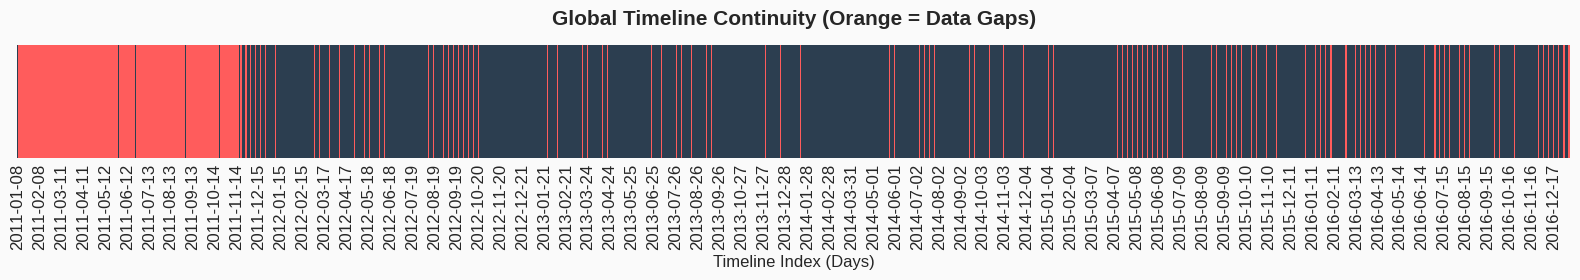

In [9]:
# -- Handling Excessive Missing Values (Find the missing dates graphically)
missing_dates(df)

**Decision**:

Most of the dates before 2012-01-01 are missing. So, I decided to drop dates before 2012-01-01.

In [10]:
# -- Remove the Date before 2012
df = df[df.date >= '2012-01-01'].reset_index(drop=True)

## **Section 2**.
### **Demand Uncertainty - Definitive Evidence Through Visualization**

In [11]:
# -- Descriptive Statistics
df.groupby('warehouse')['demand'].describe().T

warehouse         Whse_A        Whse_C        Whse_J        Whse_S
count      142197.000000  4.221900e+04  7.642540e+05  8.802600e+04
mean         1038.323945  1.378620e+04  4.400372e+03  1.173656e+04
std          4329.035898  5.921077e+04  2.119277e+04  6.478297e+04
min             0.000000  0.000000e+00  0.000000e+00  0.000000e+00
25%             3.000000  1.000000e+02  2.500000e+01  3.000000e+01
50%            50.000000  1.000000e+03  3.000000e+02  5.000000e+02
75%           550.000000  6.000000e+03  2.000000e+03  4.000000e+03
max        345200.000000  3.000000e+06  3.000000e+06  4.000000e+06

**Discussion**:

Demand distributions differ markedly across warehouses, with Whse_C and Whse_S operating at much larger scales than Whse_A and Whse_J. In all cases, means far exceed medians and standard deviations are extremely large, indicating strong right skewness and heavy-tailed demand. This highlights high uncertainty driven by rare but extreme demand spikes, limiting the reliability of average-based forecasts.

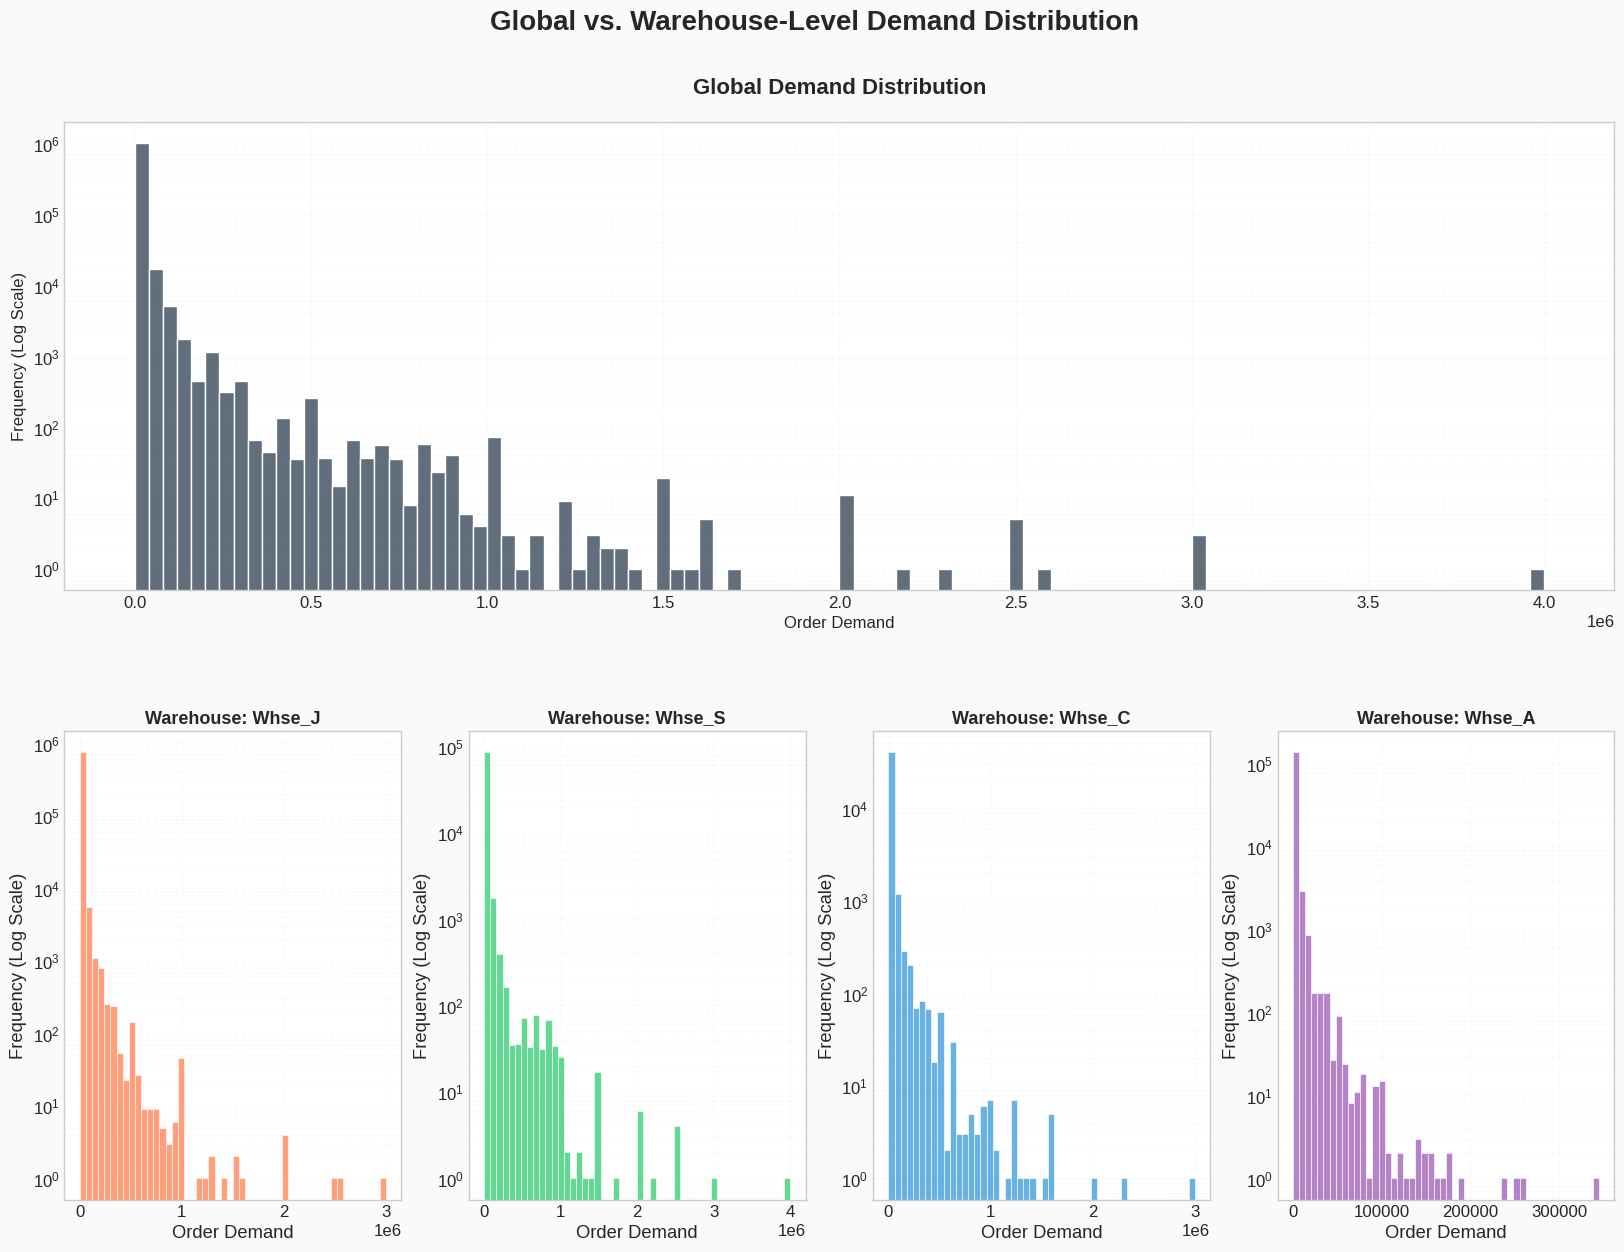

In [12]:
# -- Plot 1: Distribution of order demand (Globally & Warehouse-Level)
demand_distribution(df)

#### **Graph Insights**:

**Chart Profile**: The X-axis represents the magnitude of Order Demand, while the Y-axis (Frequency) uses a log scale to visualize extreme outliers. A "good" distribution for point-forecasting would be tightly clustered, whereas this long tail with extreme outliers is "bad."

**Observation**:

- **Global**: Demand is highly right-skewed, with most observations concentrated at low demand levels and a small number of very large orders forming a long tail.
- **Warehouse**: Across warehouses, the overall pattern is consistent with the global distribution, indicating a common demand structure. However, Whse_J and Whse_S exhibit more pronounced extreme demand values, while Whse_C and especially Whse_A show comparatively narrower demand ranges.

**Interpretation**: The dominance of low-demand observations combined with rare but extreme spikes indicates substantial demand uncertainty driven by tail events. This reduces the reliability of average-based forecasts and highlights the need for forecasting approaches that can account for skewness and extreme outcomes, particularly for warehouses with heavier demand tails.

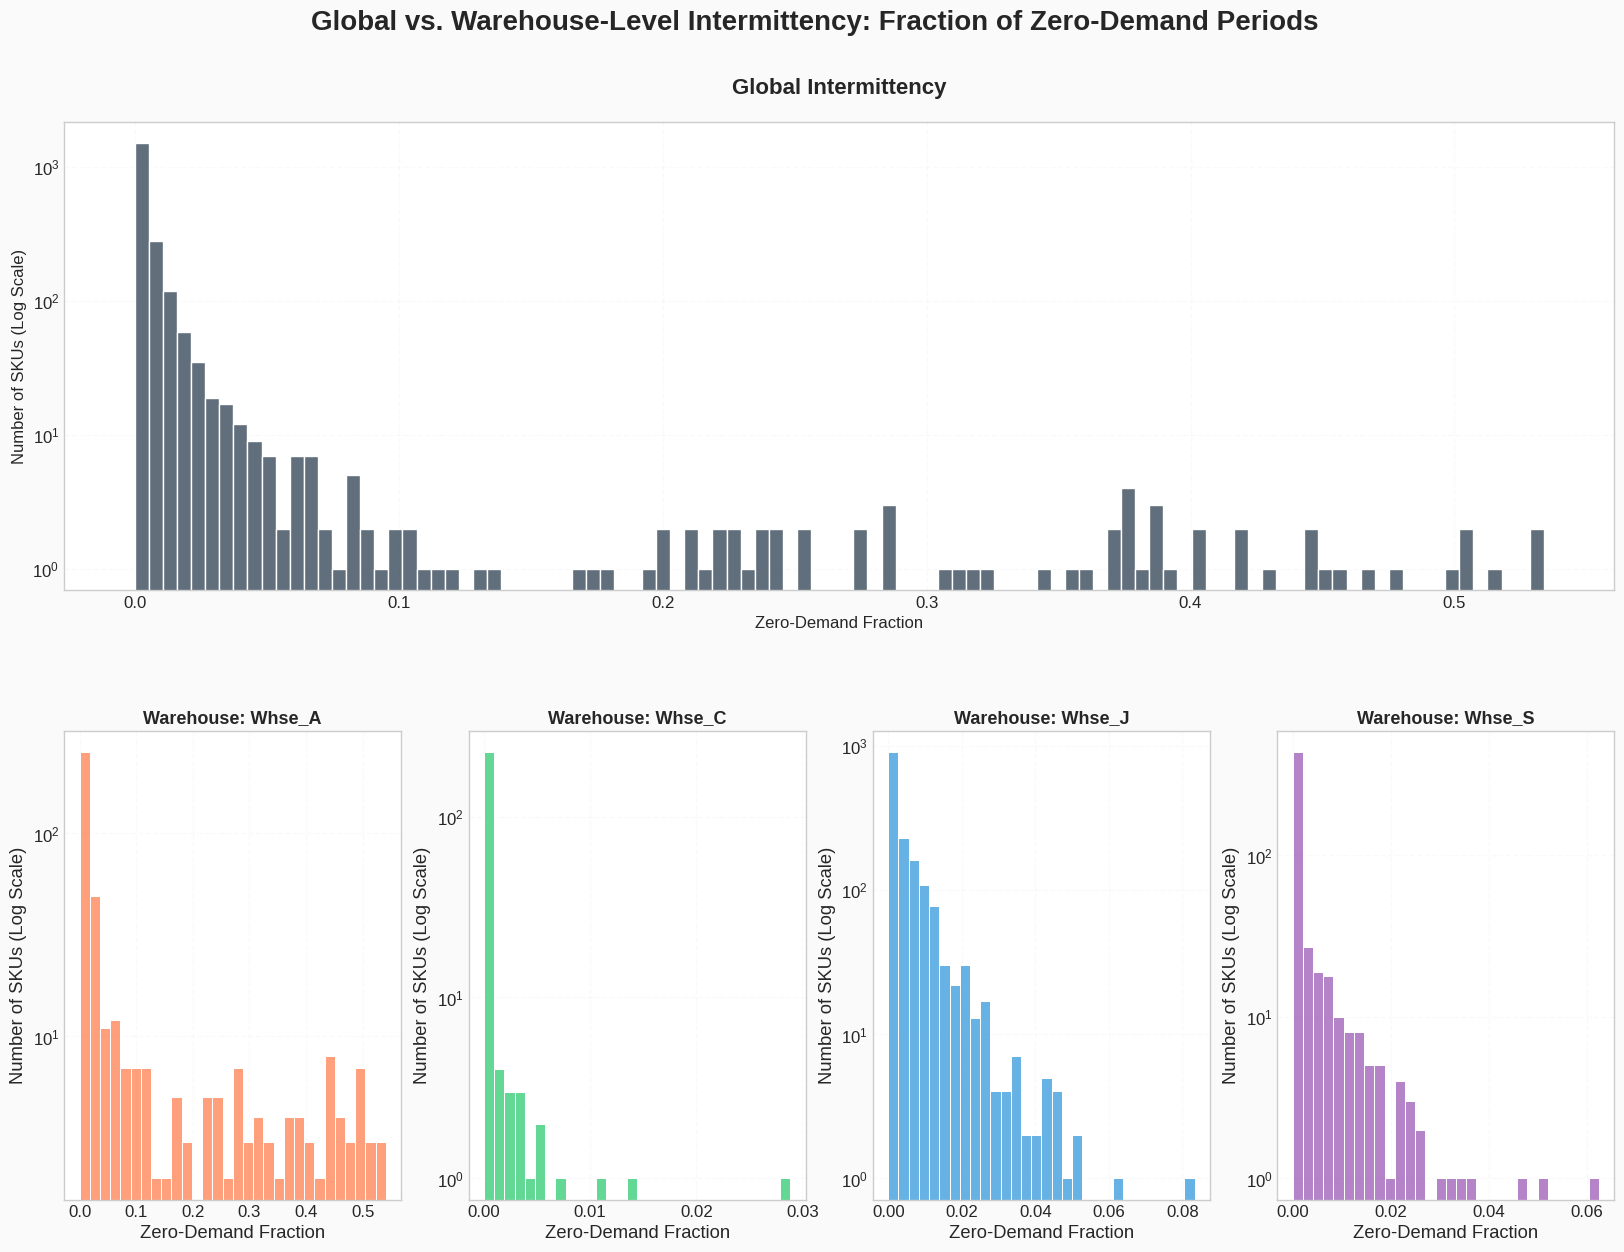

In [13]:
# -- Plot 2: Intermittency: Fraction of Zero-Demand Periods
demand_intermittency(df)

#### **Graph Insights**:

**Chart Profile**: The x-axis represents the fraction of months in which a SKU has zero demand, while the y-axis (log scale) shows the number of SKUs falling into each intermittency level. Lower values indicate more consistent demand, whereas higher values indicate increasingly intermittent demand behavior.

**Observation**:

- **Global**: A large proportion of SKUs experience zero demand in a significant share of months, while only a small subset shows consistently active demand.
- **Warehouse**: Across warehouses, the overall intermittency pattern broadly aligns with the global distribution, suggesting a shared demand structure. However, Whse_A shows a noticeably wider spread toward higher zero-demand fractions, indicating a larger share of intermittent SKUs.

**Interpretation**: The coexistence of largely regular demand with a non-trivial subset of highly intermittent SKUs highlights structural heterogeneity in the data. While much of the portfolio supports stable forecasting, the intermittent tail introduces uncertainty that can degrade forecast accuracy if treated uniformly.

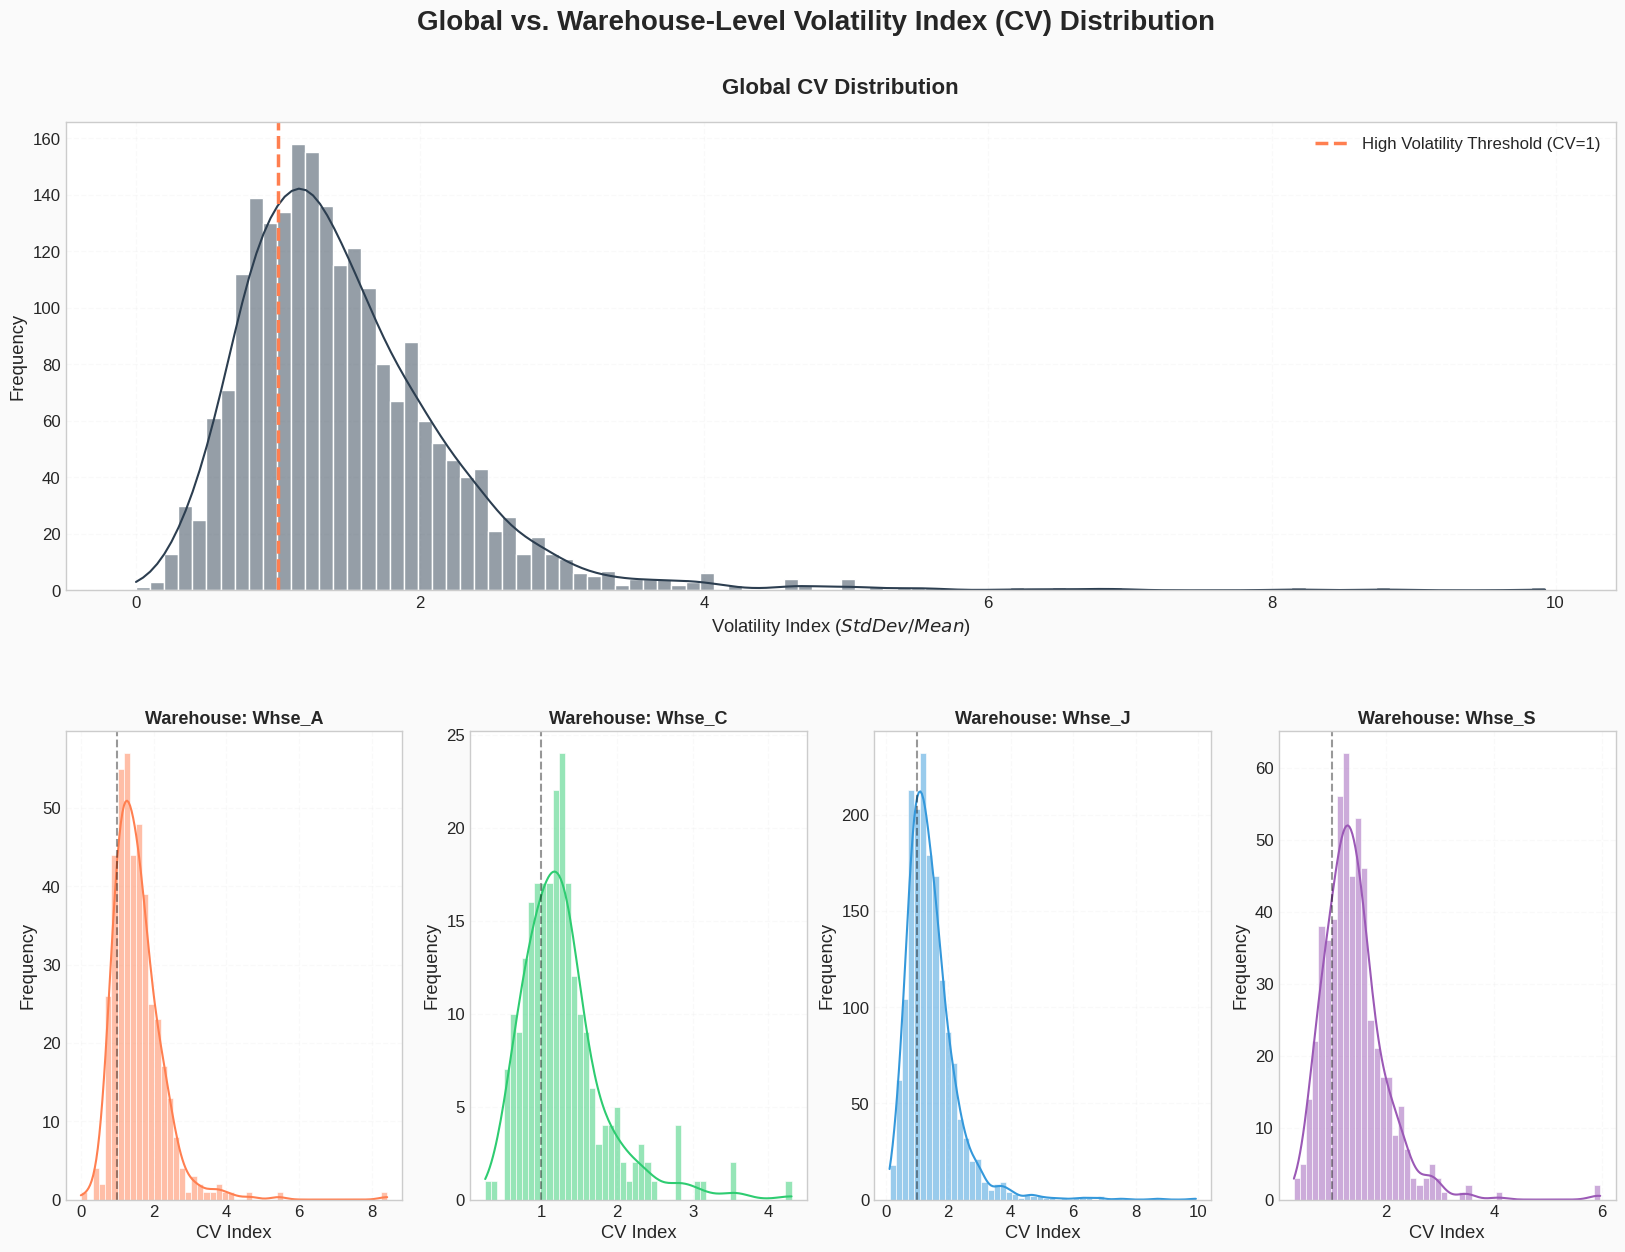

In [14]:
# -- Plot 3: Volatility Index (CV) Distribution
volatility_index(df)

#### **Graph Insights**:

**Chart Profile**: The x-axis shows the coefficient of variation (CV), measuring demand volatility relative to average demand, while the y-axis shows the number of SKUs. Lower CV values indicate more stable demand, whereas higher CV values indicate increasingly volatile and unstable demand behavior.

**Observation**:

- **Global**: A large share of SKUs lie at or above the high-volatility threshold, with a long right tail indicating extreme variability for a subset of products.

- **Warehouse**: Across warehouses, the general volatility pattern remains consistent with the global view, but the degree of dispersion varies.

**Interpretation**: The prevalence of SKUs at or above the high-volatility threshold highlights inherent instability in demand across the portfolio. This volatility introduces forecasting risk, as demand levels can vary sharply from period to period, particularly in warehouses such as Whse_J and Whse_S.

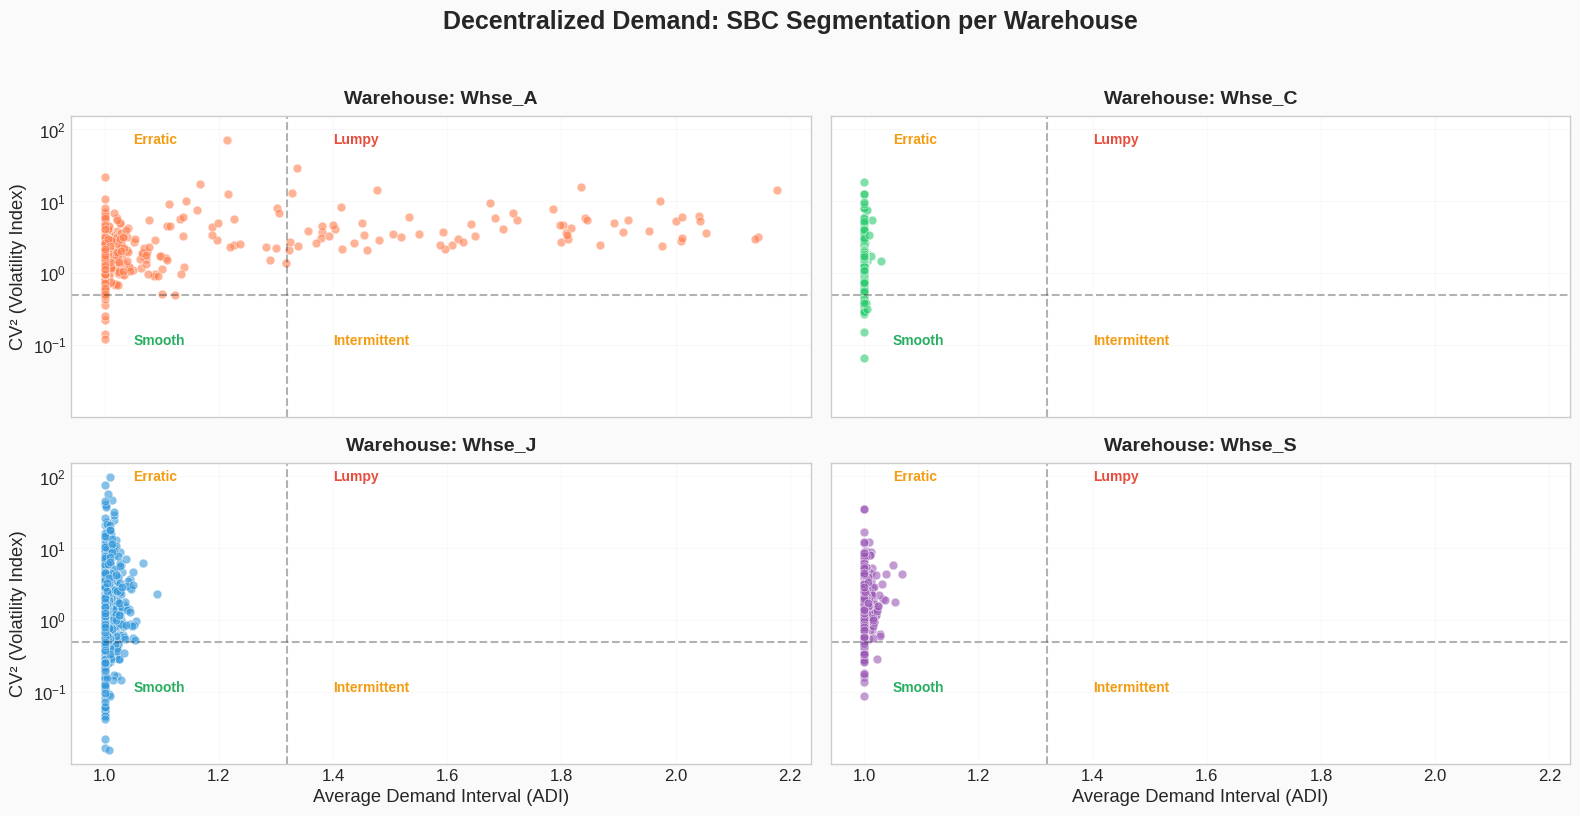

In [15]:
# -- Plot 4: SBC Segmentation per Warehouse
sbc_segmentation(df)

#### **Graph Insights**:

**Chart Profile**: The x-axis represents the Average Demand Interval (ADI), indicating how frequently demand occurs, while the y-axis represents demand size volatility (CV²), indicating how variable demand is when it occurs. Lower ADI and lower volatility indicate stable demand, whereas higher values indicate irregular and unstable demand patterns.

**Observation**: Across all warehouses, the majority of SKUs are tightly clustered around ADI values close to 1, indicating that demand is generally frequent rather than intermittent. Whse_C, Whse_J, and Whse_S show almost no spread along the ADI axis, with most SKUs falling into Smooth or Erratic regimes depending on volatility. In contrast, Whse_A is the only warehouse exhibiting a noticeable horizontal spread toward higher ADI values, resulting in the presence of Intermittent and Lumpy SKUs that are largely absent in the other warehouses.

**Interpretation**: This pattern indicates that intermittency is not a widespread issue across the network but is instead localized primarily within Whse_A. For most warehouses, forecasting complexity is driven more by volatility than by irregular demand occurrence. However, the coexistence of Smooth, Erratic, and Lumpy demand within Whse_A introduces additional uncertainty, suggesting that a single forecasting approach may be insufficient. From a business standpoint, this supports the case for warehouse-specific demand segmentation and tailored forecasting strategies, particularly for Whse_A, while simpler volatility-aware models may be adequate for the remaining warehouses.

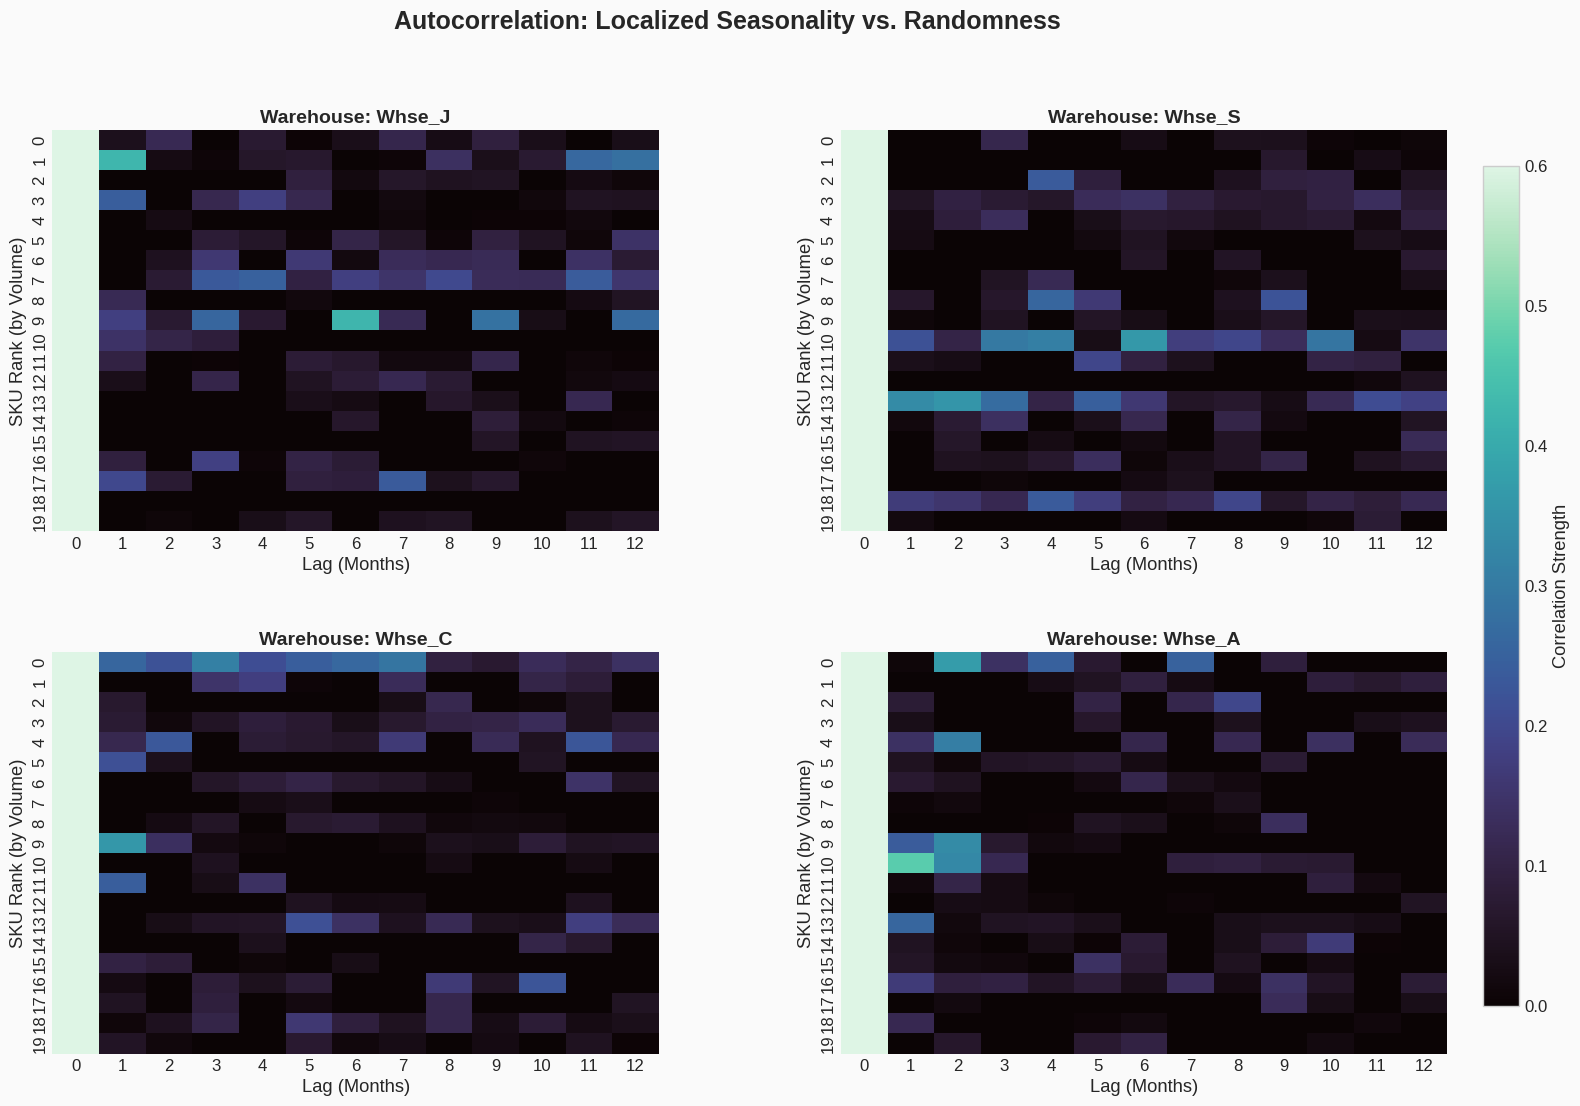

In [16]:
# -- Plot 5: Temporal dependency plot (ACF)
temporal_memory(df)

#### **Graph Insights**:

**Chart Profile**: Each heatmap shows autocorrelation strength across time lags (x-axis, in months) for a ranked set of SKUs (y-axis). Brighter colors indicate stronger autocorrelation, meaning more predictable or seasonal demand patterns at specific lags, while darker colors indicate weaker autocorrelation and more random behavior.

**Observation**: Across all warehouses, strong autocorrelation is limited to a small subset of SKUs and specific lags rather than being widespread.

**Interpretation**: The overall pattern indicates that demand dynamics are largely driven by randomness rather than strong, repeatable seasonal structures, with only limited and localized seasonality present for specific SKUs. This lack of consistent autocorrelation implies that classical seasonal forecasting assumptions may not hold broadly across the portfolio.

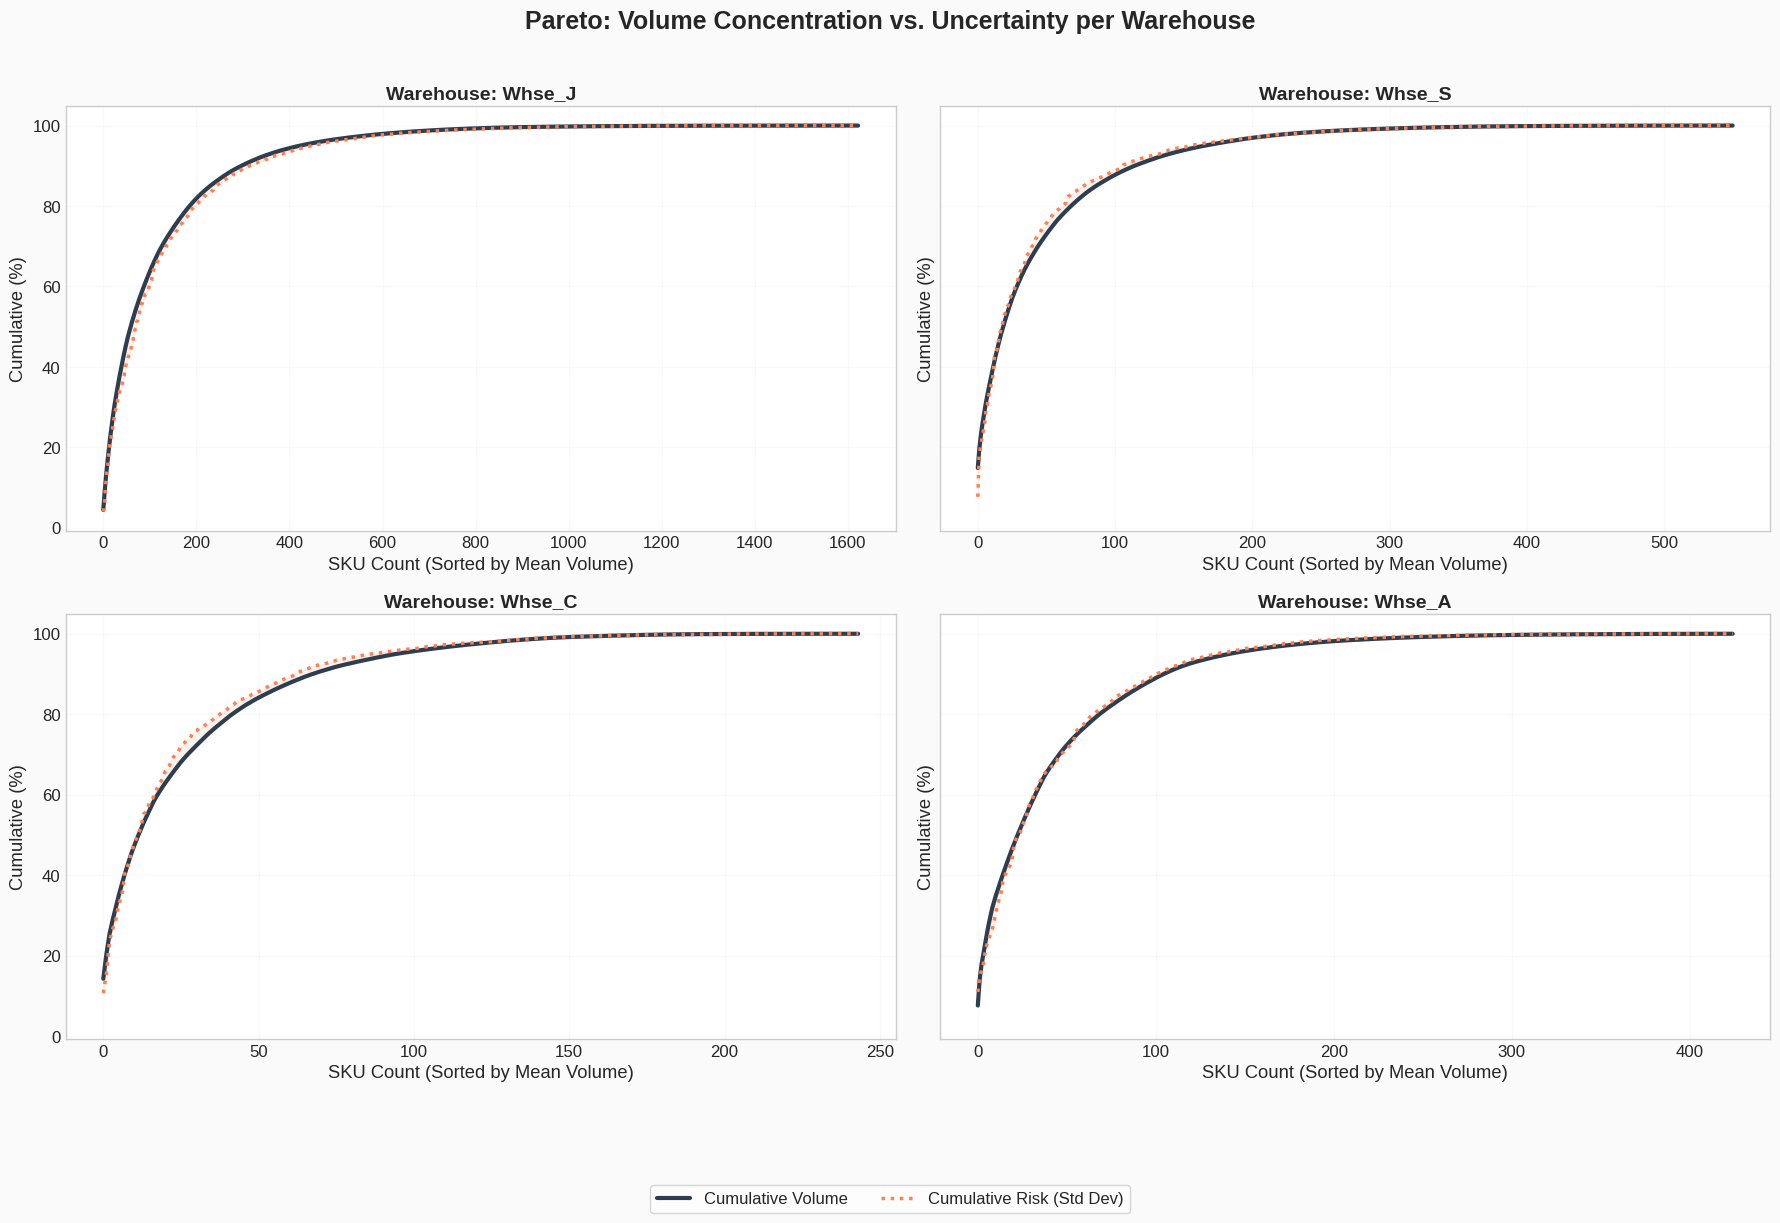

In [17]:
# Plot 6: Pareto plot
pareto_plot(df)

#### **Graph Insights**:

**Chart Profile**: The x-axis ranks SKUs by importance, while the y-axis shows the cumulative percentage of total demand volume and cumulative forecast uncertainty. A steep rise indicates that a small number of SKUs contribute disproportionately to overall impact.

**Observation**: Across all warehouses, cumulative volume rises sharply with a relatively small number of SKUs, indicating strong volume concentration consistent with a Pareto effect. In Whse_J and Whse_S, both volume and uncertainty accumulate rapidly among top-ranked SKUs, with the two curves closely aligned, suggesting that high-volume items also drive most of the variability. Whse_C shows a slightly more gradual accumulation, indicating a more balanced contribution across SKUs. Whse_A follows a similar pattern, though uncertainty accumulates marginally faster than volume in the early ranks, implying that some high-impact variability is concentrated in fewer SKUs.

**Interpretation**: These patterns indicate that a limited subset of SKUs dominates both demand volume and forecasting risk within each warehouse. From a business perspective, this creates an opportunity to focus forecasting accuracy, inventory controls, and risk mitigation efforts on a relatively small number of high-impact items.

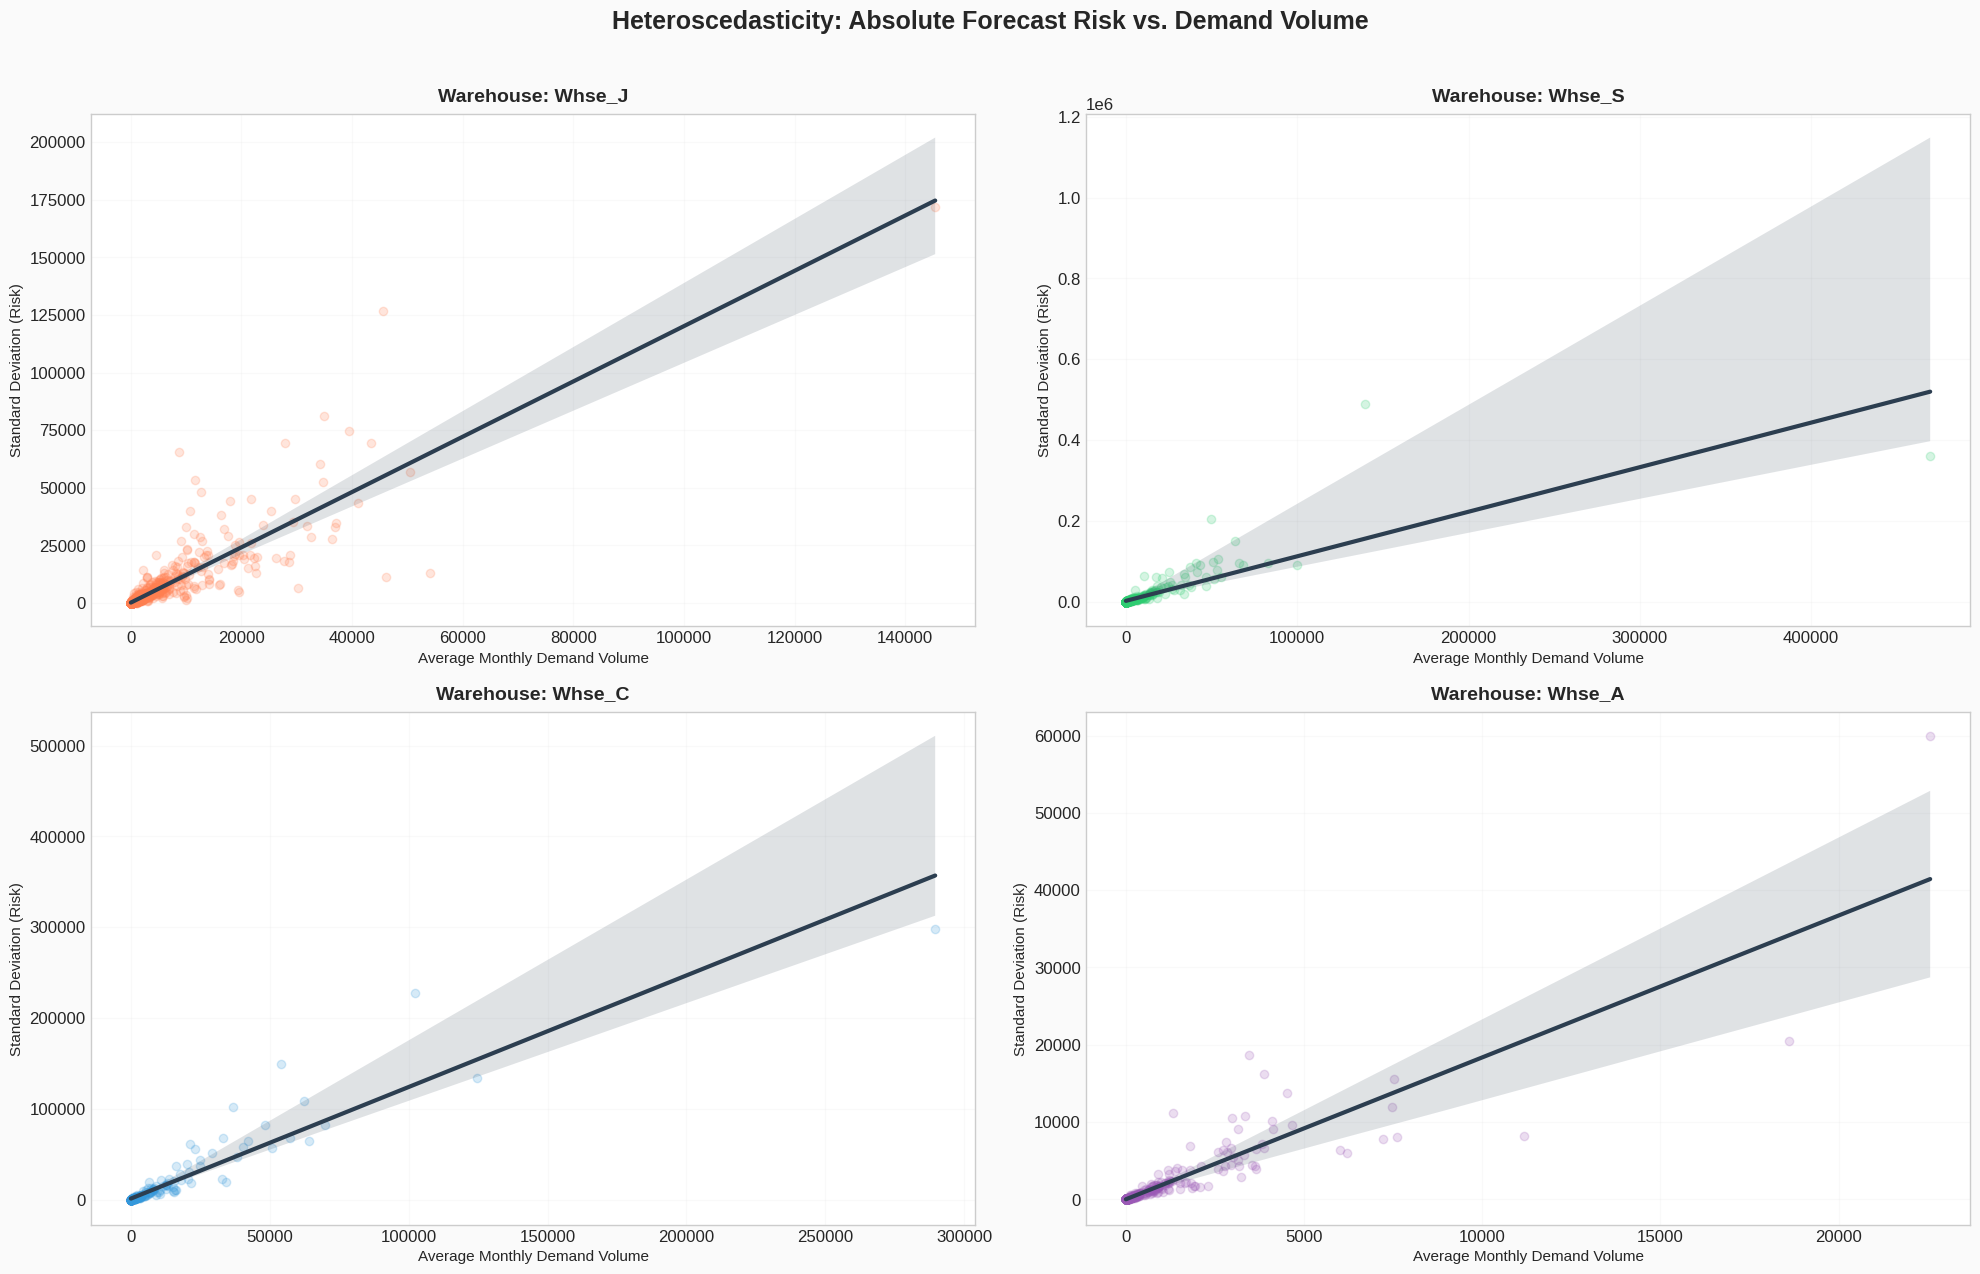

In [18]:
# -- Plot 7: Heteroscedasticity Visualization
heteroscedasticity_vis(df)

#### **Graph Insights**:

**Chart Profile**: The x-axis shows the average monthly demand volume per SKU, while the y-axis represents the standard deviation of demand, used here as a measure of absolute forecast risk. A tight, constant spread would indicate uniform predictability across demand levels.

**Observation**: Across all warehouses, there is a clear positive relationship between demand volume and absolute variability, indicating that higher-volume SKUs tend to exhibit larger absolute fluctuations. Whse_J, Whse_S, and Whse_C show pronounced widening of dispersion as volume increases, with several high-volume SKUs exhibiting disproportionately high variability. In contrast, Whse_A operates at lower demand scales overall, but still displays increasing variability with volume, albeit within a narrower range.

**Interpretation**: The observed pattern confirms the presence of heteroscedasticity, where forecast risk grows with demand scale rather than remaining constant. This implies that errors for high-volume SKUs carry substantially higher absolute impact, even if relative accuracy appears stable. From a business perspective, this reinforces the need for scale-aware evaluation metrics and forecasting models that explicitly account for increasing uncertainty at higher demand levels, particularly for warehouses handling large-volume SKUs.

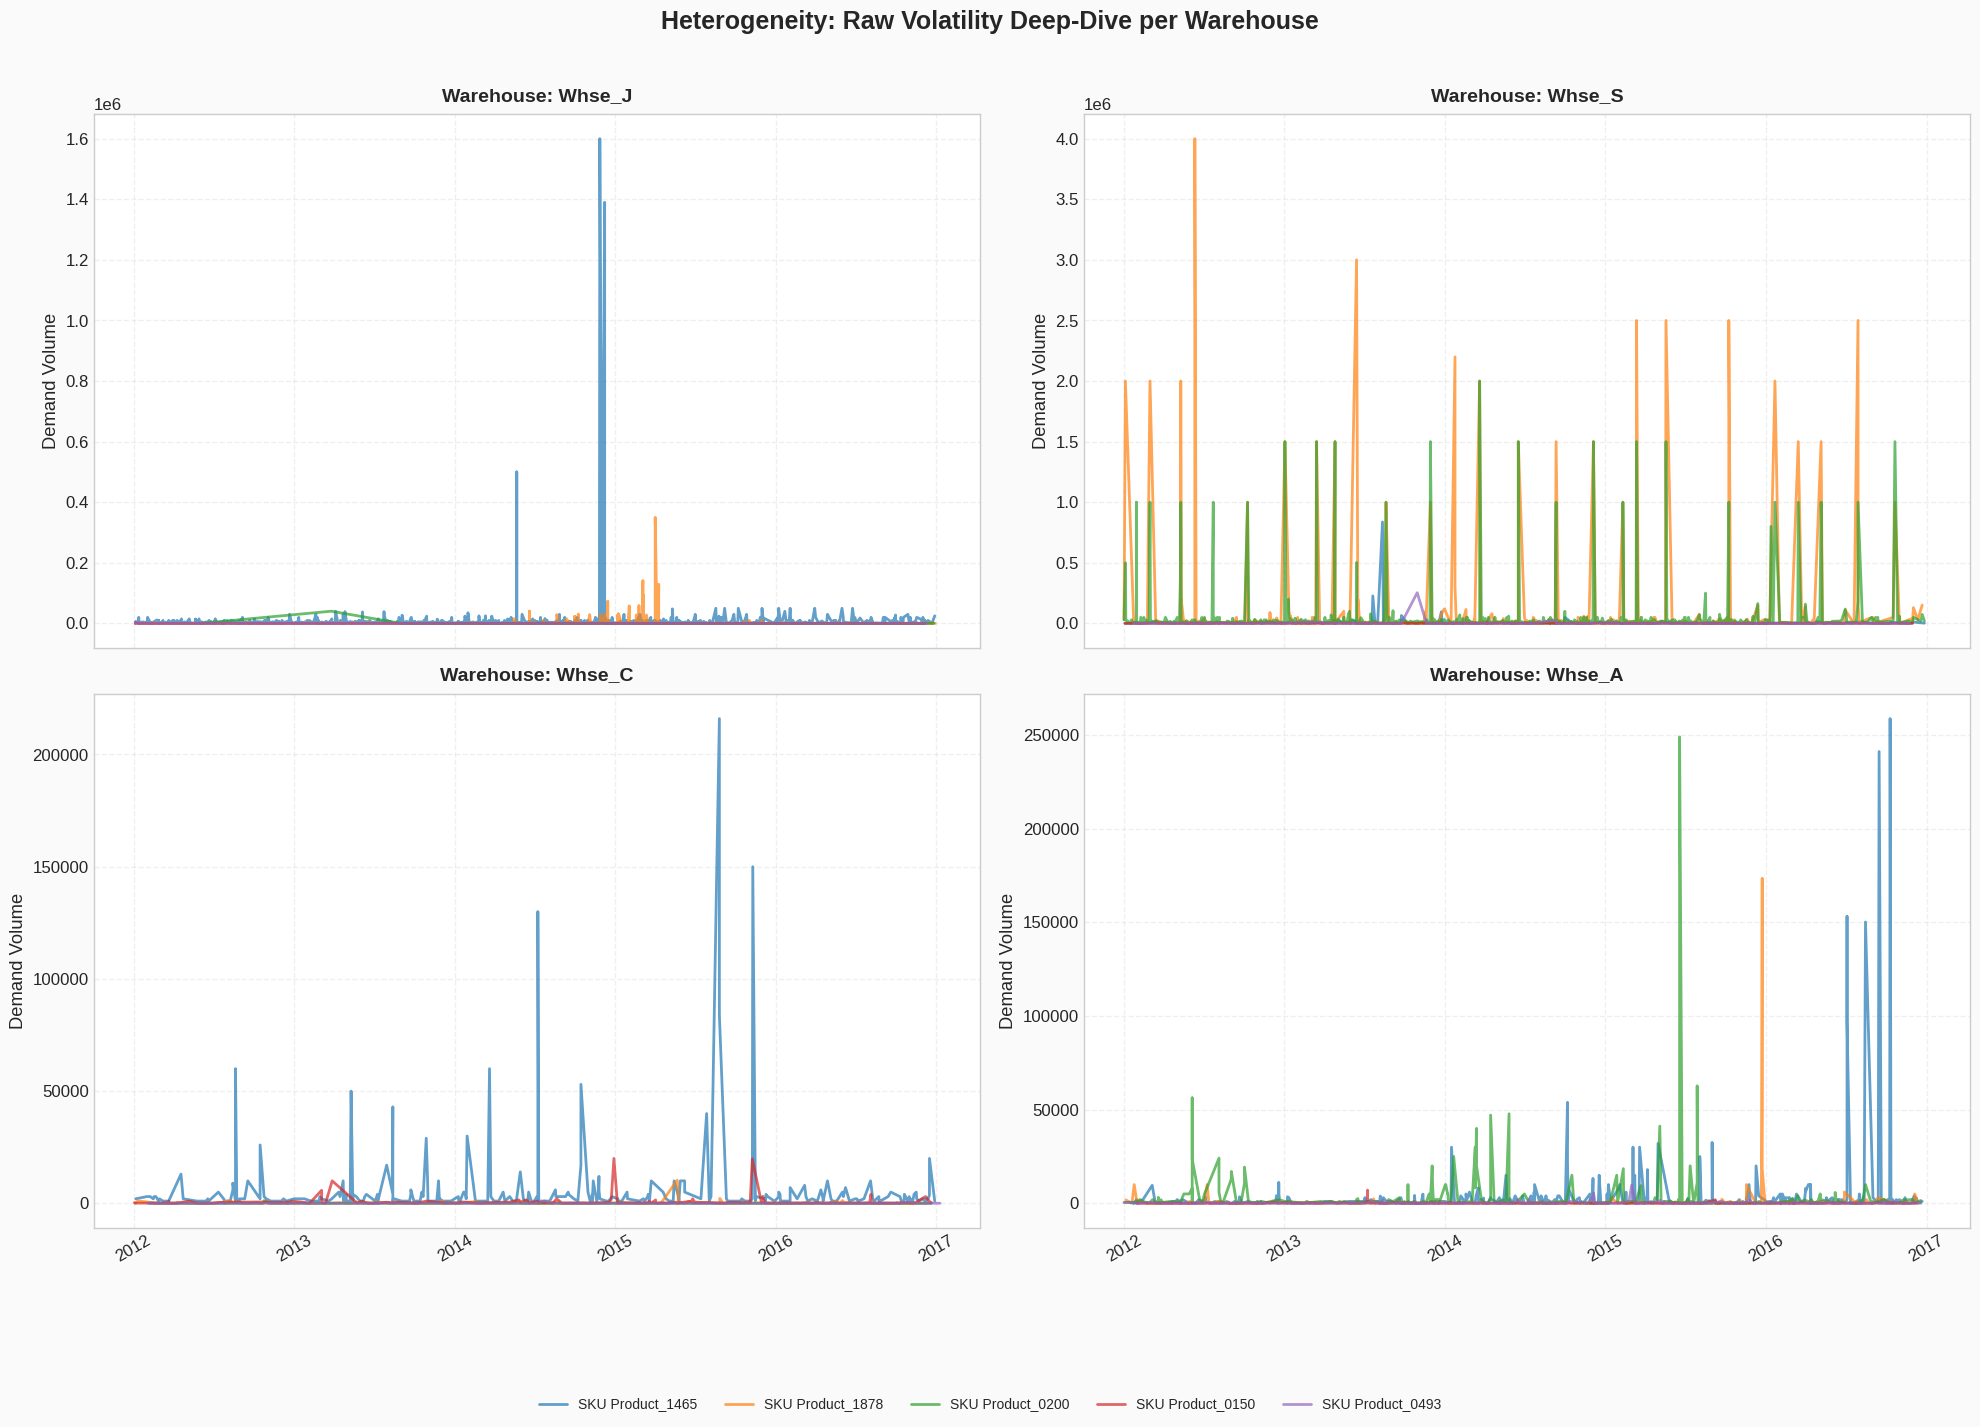

In [19]:
# Plot 8: Volatile Trajectories
volatile_trajectories(df)

#### **Graph Insights**:

**Chart Profile**: The x-axis represents the timeline, and the y-axis shows order demand volume for the top 10 most volatile SKUs. Stable demand would appear as smooth, consistent lines, while sharp spikes indicate instability.

**Observation**: Across all warehouses, demand patterns are dominated by sharp, irregular spikes rather than smooth or repeating trajectories, highlighting strong heterogeneity even among a small sample of SKUs. Whse_J and Whse_S exhibit extremely large, isolated spikes that dwarf surrounding demand levels, indicating exposure to rare but very high-volume events. Whse_C shows comparatively lower magnitudes, but still displays frequent abrupt jumps, while Whse_A operates at smaller scales overall yet continues to exhibit pronounced, SKU-specific spikes and long flat periods.

**Interpretation**: The raw time-series behavior confirms that demand volatility is driven by sporadic, high-impact events rather than stable fluctuations or consistent seasonality. This level of heterogeneity introduces significant forecasting uncertainty, as historical patterns provide limited guidance on the timing and size of future spikes.

### **Overall Summery: The Forecastability Bottleneck**

emand in the dataset is highly heterogeneous, intermittent, and heavy-tailed, with extreme volume concentration and volatility driven primarily at the product level rather than the warehouse level. Pareto and distribution plots show that a small fraction of SKUs contributes the majority of total demand and forecast risk, while most SKUs exhibit sparse or low-volume behavior. SBC (ADI–CV²) analysis confirms that all warehouses share similar demand regimes, dominated by smooth and erratic patterns, with differences arising mainly in volatility magnitude rather than structural behavior. Autocorrelation and temporal heatmaps indicate weak and inconsistent seasonality, especially outside high-volume SKUs, limiting the effectiveness of purely sequence-driven models. Heteroscedasticity plots further demonstrate that forecast error scales with demand volume, implying that absolute-error metrics (MAE/RMSE) are dominated by a small number of high-volume products. Overall, the data characteristics indicate that uncertainty is intrinsic to the demand process and cannot be eliminated through model complexity alone.

Moreover, the dataset lacks key causal and explanatory drivers that are critical for achieving consistently high forecast accuracy. The dataset
provides core transactional demand information- SKU, warehouse, category, time, and historical demand, which is adequate for studying demand behavior, uncertainty, and large-scale forecasting feasibility. Important factors such as pricing, promotions, stock-outs, lead times, marketing actions, holidays, and external economic or environmental signals are not available.

## **Section 3**.
### **Modeling Strategy: Why Temporal Fusion Transformers Are Appropriate**

#### **Why TFT**:

*****I utilized the Temporal Fusion Transformer (TFT) to better understand and model the complex demand patterns present in the data.*****

The TFT is a state-of-the-art deep learning architecture designed specifically for "multi-horizon" time series forecasting. Unlike standard sequence models, the TFT integrates several advanced mechanisms to handle the inherent challenges of large-scale demand planning, such as the lumpy demand patterns, extreme scale disparities, and high volatility observed in this dataset. TFT excels with intermittent demand via variable selection networks that suppress irrelevant historical signals and focus on sparse, high-impact events—key for $CV >1.0$ and irregular ADI. Given the high level of intermittency, heteroscedasticity, and weak temporal dependency across SKUs, TFT’s global learning framework allowed shared patterns to be extracted across thousands of products while remaining flexible to individual SKU behavior. Its attention and gating mechanisms helped identify which historical signals were informative and which were largely noise. Most importantly for warehouse management, the TFT moves beyond simple point estimates to provide probabilistic quantile forecasts (e.g., P50, P80, P90). This capability allows stakeholders to manage the extreme uncertainty and heteroscedasticity of the data by defining clear risk boundaries, such as using the P50 for standard replenishment and the P90 as a "safety stock" lever to mitigate the risk of stockouts during unpredictable demand spikes.

*****I had chosen a "Global Model" (TFT) with long-format data structure over separate warehouse models.*****

Training separate models for each warehouse is ineffective in this dataset because many SKUs have short, sparse, and highly intermittent demand histories at the warehouse level. By contrast, a single global model trained on long-format data enables information sharing across all SKUs and warehouses. This approach allows the model to learn common demand dynamics, volatility regimes, and scale effects from the entire dataset, while still preserving warehouse- and product-specific behavior through static covariates. Furthermore, global modeling supports consistent probabilistic forecasting across the network, enabling coherent risk assessment and comparison between products and warehouses.

## **Section 4**.

### **Model Training and Experimental Setup**

#### **Modeling Strategy by Demand Segment**:

*****I was first segment products based on demand sparsity*****

Products are first segmented based on demand sparsity, defined as the number of non-zero demand occurrences within the historical horizon, because forecastability depends on the frequency of observed demand events rather than model complexity.

| Non-zero demand events | Segment interpretation         |
| ---------------------- | ------------------------------ |
| ≤ 3                    | Non-recurrent demand (One_off) |
| 4–6                    | Intermittent demand            |
| ≥ 7                    | Regular / Learnable demand     |

*****Different modeling approaches are then applied to each segment*****

| Demand Segment              |  Selected Model                    | Rationale                                                                                                                                                                                                                               |
| --------------------------- | ---------------------------- | --------------------------------------------------------------- |
| **Regular / Learnable**     | **Global TFT**                    | Sufficient data density exists to learn temporal structure. TFT leverages cross-product and cross-warehouse information, captures covariate effects, and provides probabilistic forecasts to model heteroskedastic uncertainty.         |
| **Intermittent**            | **TSB / SBA**                     | Demand timing cannot be reliably forecasted, but demand rate remains estimable. Intermittent-demand methods explicitly model demand size and occurrence probability, producing unbiased and stable estimates without overfitting noise. |
| **One-off / Non-recurrent** | **No statistical model (Policy)** | Insufficient statistical signal exists to estimate demand level or variability. Any forecast would be unreliable; such items are best managed through manual or policy-based planning.                                                  |



#### **Structure data into Long Format (TFT)**

In [21]:
# -- Aggregation to Monthly
df = df.groupby([
    'product_code', 'warehouse', pd.Grouper(key='date', freq='MS')
]).agg({'demand': 'sum', 'product_category': 'first'}).reset_index()

In [22]:
# -- Compute first sale date per SKUs–warehouse
first_sale = (df[df["demand"] > 0].groupby(["product_code", "warehouse"])["date"].min().reset_index(name="first_sale_date"))
# Merge into main dataset
df = df.merge(first_sale, on=["product_code", "warehouse"], how="left")

In [23]:
# -- Fill missing date for Temporal continuty
df = fill_missing_dates(df)

In [24]:
print(f'About {round((df[df.demand == 0].shape[0]/df.shape[0])*100, 3)}% rows have Zero demand.')

About 17.844% rows have Zero demand.


#### **Decision**:

Make a flag for Product_Code X Warehouse.
-  greater than equal 7 - **normal**
- <= 3 - **one_off**
- 3 < x < 7 - **intermediate**

In [ ]:
# -- Filter Sparse Product Code X Warehouse combo
df = sparcity(df)

#### **Feature Engeenering**

In [26]:
# -- Create Volume (ABC) & Volatality (XYZ) segments accorsing to SKUs historical demand
segment_results = perform_abc_xyz_segmentation(df)
# -- Merging with Segments
df = df.merge(segment_results[['product_code', 'warehouse', 'segment']], on=['product_code', 'warehouse'], how='inner')

In [27]:
# -- Order Demand to Log Demand
df['log_demand'] = np.log1p(df['demand'])

#### **Decision**:

*****I applied $Log (1+x)$ transformation to the order demand values.*****

Although Yeo–Johnson marginally improves skewness metrics, log1p was selected for its stability, interpretability, and alignment with the multiplicative and uncertain nature of demand data, without introducing unnecessary transformation complexity.


In [28]:
# -- FE: Time Index for TFT
df['time_idx'] = (df['date'].dt.year * 12 + df['date'].dt.month)
df['time_idx'] -= df['time_idx'].min()
# -- FE: Time Known Future Features
# 1. Sin/Cos Encoding of Month (Cyclic Seasonality)
# This helps the model realize Month 12 is next to Month 1
df['month_sin'] = np.sin(2 * np.pi * df['date'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['date'].dt.month / 12)
# -- 2. International Holiday Month (Proxy)
df['is_global_holiday_month'] = df['date'].dt.month.isin([11, 12]).astype(int)

#### **Notice**:

`Quarterly` aggregation was not used because monthly sine–cosine features capture seasonality without losing temporal resolution, whereas quarterly aggregation would oversmooth already sparse and uncertain demand.

In [29]:
# -- Organize the dataframe
df = df[
    ['date', 'time_idx', 'product_code', 'warehouse', 'product_category', 'month_sin', 'month_cos',
    'is_global_holiday_month', 'log_demand', 'demand', 'segment', 'sparsity_flag']
]

## **Section 5**.
### **Model Diagnosis**

In [30]:
# -- Initialized the model
max_prediction_length = 2
max_encoder_length = 12
training_cutoff = df["time_idx"].max() - max_prediction_length

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="log_demand",
    group_ids=["product_code", "warehouse"],

    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,

    static_categoricals=["segment", "product_category"],
    time_varying_known_categoricals=[],
    time_varying_known_reals=[ "month_sin", "month_cos", "is_global_holiday_month"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=["log_demand"],
    target_normalizer=GroupNormalizer(
        groups=["product_code", "warehouse"],
        transformation=None
    ),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

tft = TemporalFusionTransformer.from_dataset(
    training, learning_rate=5e-4, hidden_size=16, lstm_layers=1,
    attention_head_size=4, dropout=0.3, hidden_continuous_size=8,
    loss=QuantileLoss([0.5, 0.8, 0.9]), optimizer="adam",
    reduce_on_plateau_patience=4,
)

In [31]:
# -- Load fitted model
device = torch.device('cpu')
tft.load_state_dict(torch.load("/content/drive/MyDrive/DemandForecastAnalysis/demandforecast_tft_28D01M26Y_version_02.pth", map_location=device))

<All keys matched successfully>

In [32]:
# -- Predicted data view
diags, predictions = diagnosis_frame(df, tft, training, segment_results)
diags.head()

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


product_code warehouse  time_idx    actual  horizon       p50       p80  \
0  Product_0001    Whse_A         6  8.987322      1.0  8.539255  9.045198   
1  Product_0001    Whse_A         7  8.764210      2.0  8.530187  9.034914   
2  Product_0001    Whse_A         8  8.630700      1.5  8.608696  9.071854   
3  Product_0001    Whse_A         9  9.525224      1.5  8.648531  9.105561   
4  Product_0001    Whse_A        10  8.412055      1.5  8.681560  9.170934   

        p90 segment  
0  9.284582      CY  
1  9.290016      CY  
2  9.309538      CY  
3  9.332006      CY  
4  9.393849      CY

#### **Diagnosis plots**

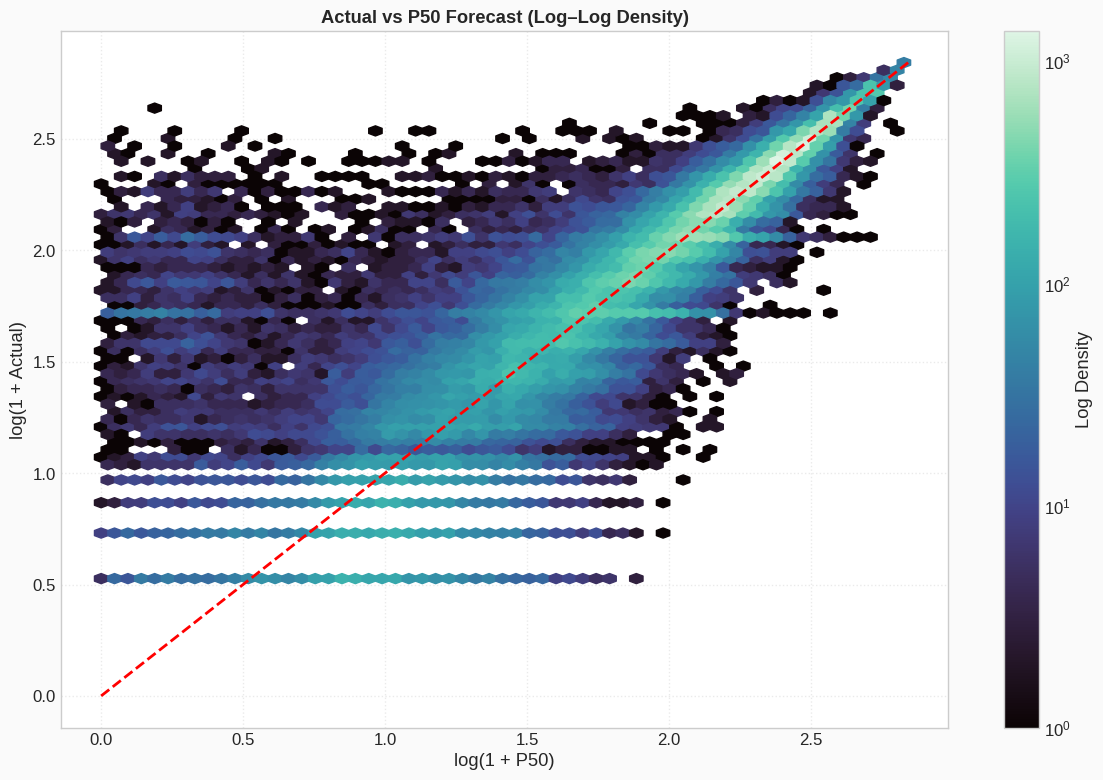

In [33]:
# -- Plot 1: Actual vs P50 Forecast (Log–Log Density)
actual_vs_predicted(diags)

#### **Graph Insights**:

**Chart Profile**: Both axes show log-transformed values of actual demand and the P50 forecast, with color intensity representing observation density. The red dashed diagonal denotes perfect prediction, where forecasted and actual values are equal.

**Observation**: The highest-density region aligns closely with the diagonal across mid-to-high demand levels, showing that TFT consistently learns the correct demand scale. At low demand levels, the density spreads vertically and forms horizontal bands, indicating intermittent and discrete demand that is difficult to predict deterministically.

**Interpretation**: The TFT demonstrates strong performance in capturing demand magnitude and scaling behavior without systematic bias. The remaining dispersion is driven by inherent data intermittency rather than model weakness, confirming that TFT is effective for level estimation while uncertainty in low-volume regions should be managed through probabilistic forecasts rather than point accuracy alone.

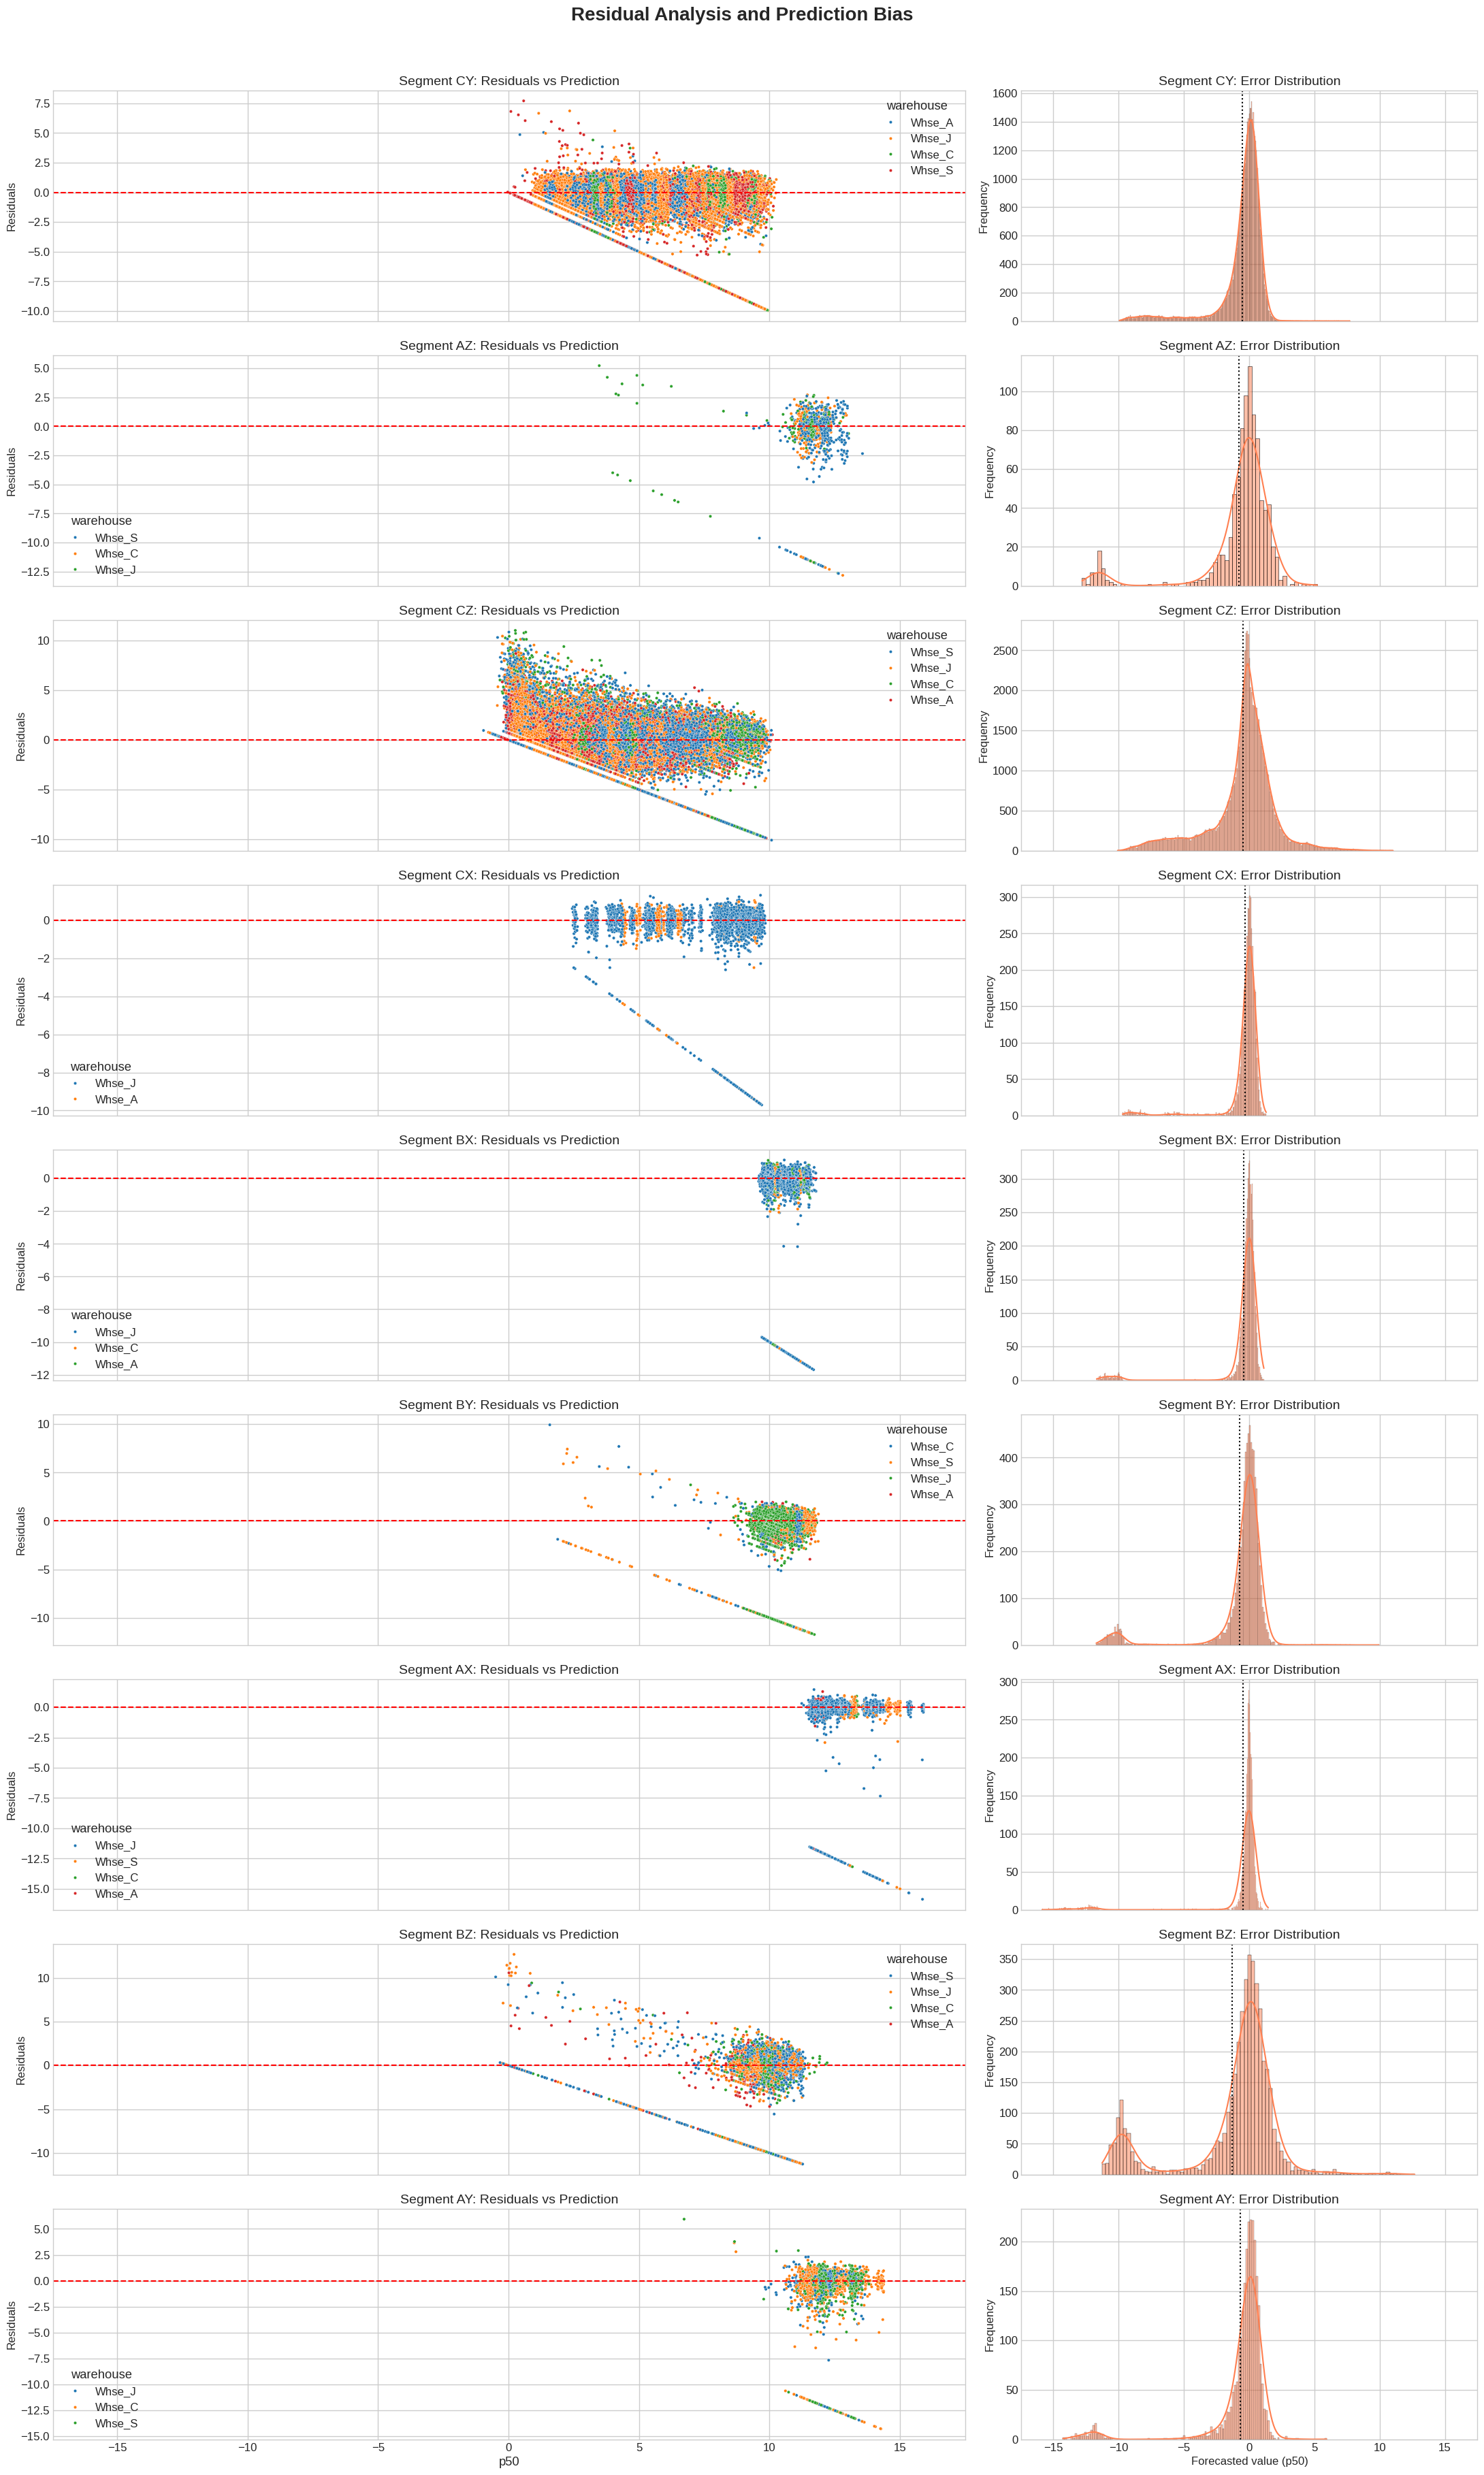

In [34]:
# -- Plot 2: Residual Plot and Distribution of Residuals (Per Segments)
residual_plots(diags)

#### **Graph Insights**:

**Chart Profile**: Each row corresponds to one ABC–XYZ segment. The left panel shows residuals (actual − P50 forecast) versus predicted demand, colored by warehouse, while the right panel shows the residual distribution for the same segment. Points centered around zero indicate unbiased predictions, whereas spread, skewness, and shape reveal uncertainty structure and forecastability.

**Observation**: Across segments, residual behavior differs far more by business segment than by warehouse, indicating that segment characteristics dominate forecast error dynamics. High-uncertainty segments such as CY, CZ, and BZ display pronounced funnel-shaped residual patterns with wide dispersion and clear heteroscedasticity, confirming that forecast error magnitude increases with demand level. Their error distributions are broad and often skewed, reflecting noise-dominated demand driven by sporadic spikes. Mid-stability segments (AY, BY, AZ) show moderate dispersion with residuals still centered near zero but with noticeable asymmetry, indicating partial predictability. In contrast, stable, high-importance segments (AX, BX, CX) exhibit tightly clustered residuals around zero with narrow, symmetric distributions, signaling strong forecastability and minimal bias across warehouses.

**Interpretation**: This segmented view clearly demonstrates that the forecastability bottleneck is structural and regime-specific, not a consequence of warehouse effects or model misspecification. The TFT behaves consistently across warehouses, but the achievable accuracy ceiling varies sharply by segment due to inherent demand characteristics. Stable segments support reliable point forecasts, while volatile and low-importance segments are fundamentally uncertainty-driven and require interval-based decision support rather than accuracy optimization. From a business perspective, this validates the use of segment-specific evaluation criteria and reinforces the need to align forecasting objectives with risk exposure rather than pursuing uniform accuracy across the portfolio.

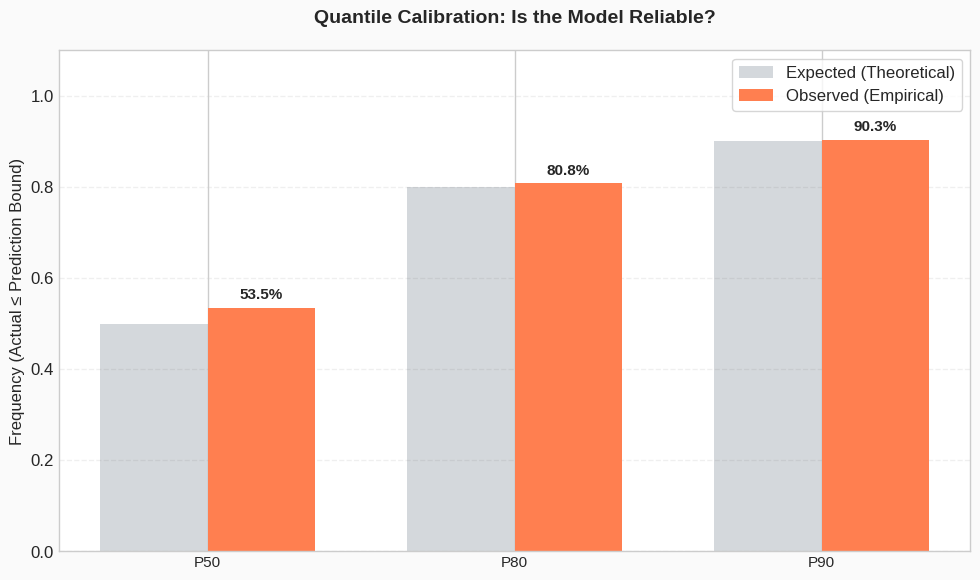

In [35]:
# -- Plot 3: Quantile Calibration Coverage
qcc_plot(diags)

#### **Graph Insights**:

**Chart Profile**: The bars compare theoretical quantile coverage with empirical coverage, showing how often actual demand falls below the P50, P80, and P90 prediction bounds. Perfect calibration occurs when observed coverage matches the expected level.

**Observation**: The model slightly over-covers at the median, with P50 capturing approximately 53.5% of observations instead of the expected 50%, indicating a mild conservative bias around the center. Coverage at higher quantiles improves further, with P80 at 80.8% and P90 at 90.3%, both closely aligned with their theoretical targets.

**Interpretation**: The model demonstrates strong probabilistic reliability, particularly in the upper quantiles that are most relevant for risk-sensitive planning. The small over-coverage at P50 suggests limited bias rather than systematic miscalibration, while the near-perfect alignment at P80 and P90 indicates that uncertainty bands are appropriately sized. From a business perspective, this level of calibration supports using the forecast intervals for decision-making, even in the presence of high demand volatility.

## **Section 6**.
### **Forecast-Driven Inventory Decision Framework**

#### **Forecast**

In [37]:
# -- Get next month forecast
forecast_df = forecast_horizon(history= df.copy(), forecast_len= 2, training= training, model= tft)

INFO: 💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores


#### **Risk Summary Table**

In [38]:
# -- Safety stock
forecast_df['safety_stock_units'] = forecast_df['p90'] - forecast_df['p50']

In [39]:
# -- Warehouse-level inventory risk summary
warehouse_risk = forecast_df.groupby('warehouse').agg({
        'p50': 'sum', 'p90': 'sum', 'safety_stock_units': 'sum'
    }).reset_index()

# Volatility Ratio (How much extra space we need vs. average)
warehouse_risk['risk_multiplier'] = (warehouse_risk['p90'] /warehouse_risk['p50'].replace(0, np.nan))

# Gradient
warehouse_risk.style.background_gradient(subset=["safety_stock_units", "risk_multiplier"], cmap="RdYlGn_r", low=0.3, high=0.3).format({"p50":"{:,.0f}","p90":"{:,.0f}","safety_stock_units":"{:,.0f}","risk_multiplier":"{:.2f}"})


#### **Table Insights**:

**Color Profile**: Green indicates low inventory risk and stable demand, yellow/amber reflects moderate uncertainty requiring cautious buffer planning, and red highlights high upper-tail demand risk where significant safety stock is needed to absorb potential demand spikes.

**Observations**: Inventory risk is unevenly distributed across warehouses, with some locations showing disproportionately high volatility relative to their average demand, despite not always having the highest volumes.

**Business Decision**: Warehouses flagged as high risk should plan inventory using P80–P90 forecasts and tighter monitoring, while medium-risk warehouses apply selective buffering and low-risk warehouses rely on baseline (P50) planning to optimize working capital and service levels.

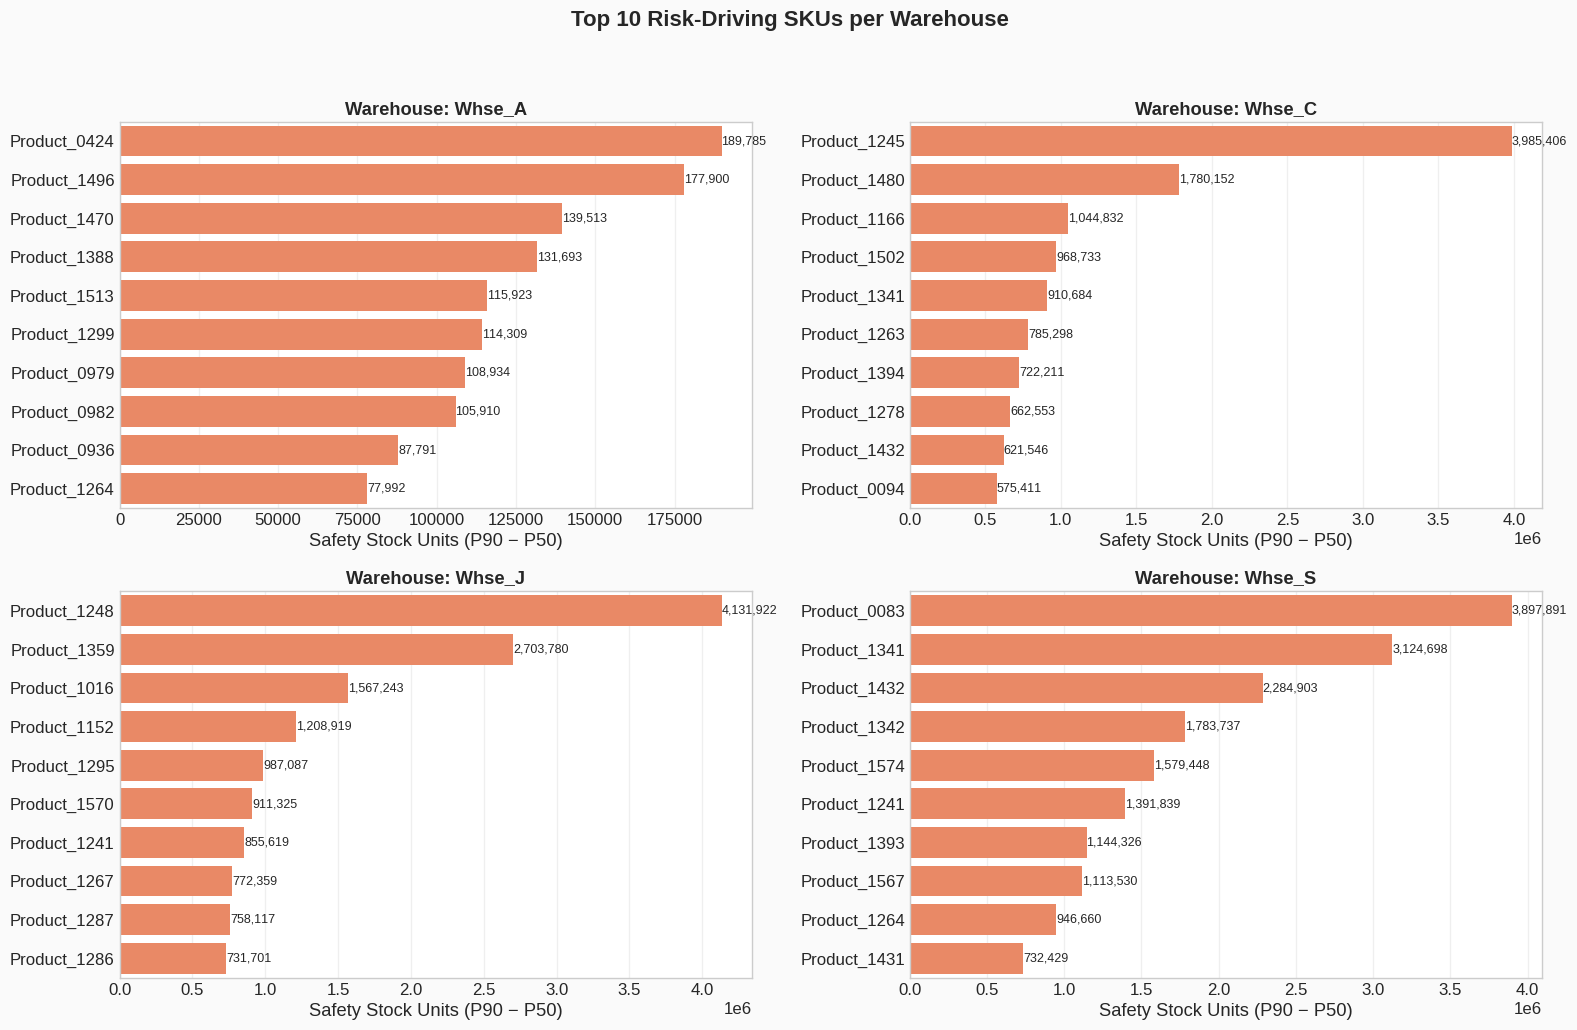

In [40]:
# -- Plot 1. Risk-Driving SKUs
risk_driving_skus(forecast_df)

#### **Graph Insights**:

**Chart Profile**: Each panel corresponds to a warehouse. Within each panel, the y-axis lists the top 10 SKUs ranked by inventory risk, and the x-axis shows safety stock units, defined as the difference between P90 and P50 forecasts (P90 − P50). Longer bars indicate SKUs that require more additional inventory to hedge against high-demand scenarios.

**Observation**: There is a strong warehouse-specific concentration of risk.
- Whse_A shows relatively lower absolute safety stock requirements, with risk spread more evenly across its top SKUs.

- Whse_C, Whse_J, and Whse_S exhibit much larger safety stock magnitudes, where the top one or two SKUs dominate the risk profile by a wide margin.
Across all warehouses, only a small subset of SKUs accounts for the majority of safety stock needs.

**Business Decision**: Focus inventory buffers and replenishment decisions on the small set of high-risk SKUs identified in each warehouse, using higher-quantile (P80–P90) forecasts, while managing the remaining products with baseline (P50) planning. This targeted approach reduces stockout risk where it matters most without unnecessarily increasing overall inventory or tying up working capital.

## **Overall Business Summary**

**Observation**:

Across warehouses and business segments, demand risk is highly concentrated and asymmetric. A small subset of SKUs and segments generates a disproportionate share of upside demand risk, as evidenced by large P90–P50 gaps, while the majority of products remain relatively stable. Risk intensity varies significantly by warehouse—some locations face moderate volume but extreme uncertainty—confirming that average demand alone is not a reliable basis for inventory planning.

**What the business should do**:

Adopt a risk-segmented inventory strategy. Use P80–P90 planning and tighter review cycles for high-risk segments and the top risk-driving SKUs in each warehouse; allocate buffer capacity and working capital accordingly. Manage the remaining portfolio with P50-based planning, avoiding blanket safety stock increases. This targeted approach protects service levels where volatility is real while minimizing excess inventory and capacity waste across the network.

#### **Forecast Horizon from history to next two month (Per Business Segments)**

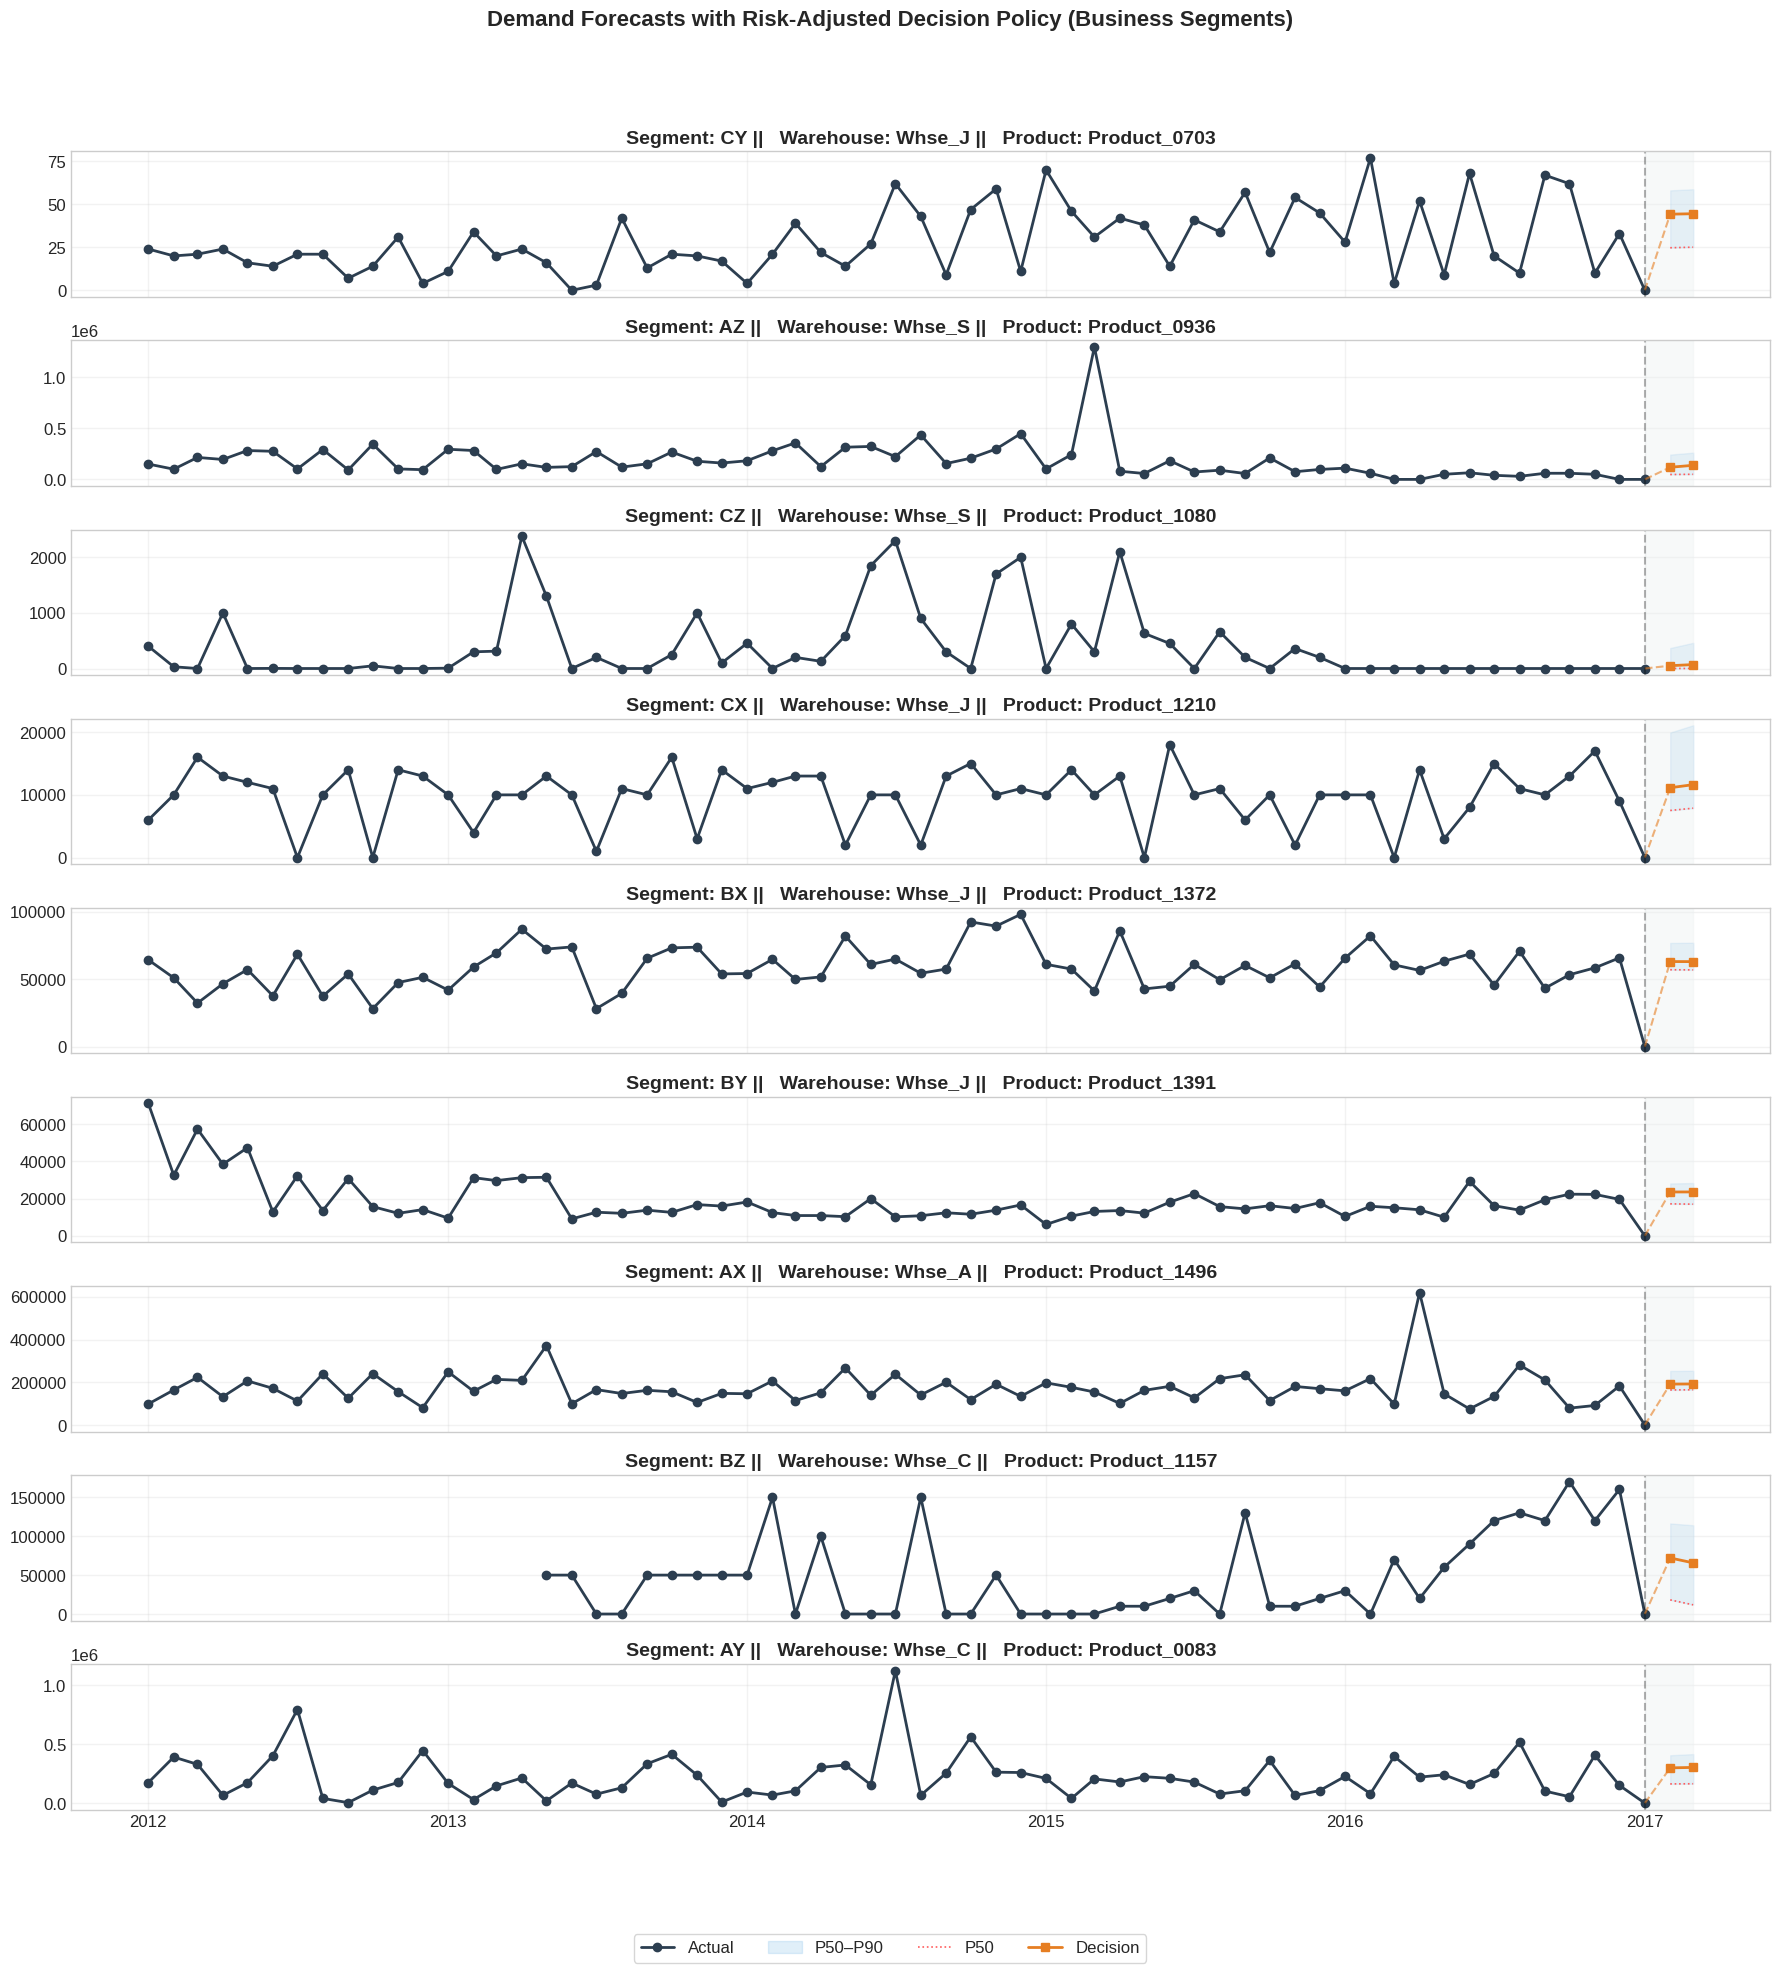

In [ ]:
# Plot 2. Demand Forecasts with Risk-Adjusted Decision Policy (Business Segments)
forecast_nx_mn(df, forecast_df)


# **Conclusion**

This project demonstrates that large-scale demand forecasting in real-world supply chains is fundamentally constrained by structural uncertainty, intermittency, and heteroscedastic demand behavior, rather than modeling limitations alone. Despite applying advanced transformations to address skewness and scale, uncertainty in demand—especially in the upper tail—cannot be eliminated through preprocessing. As shown, demand risk is highly concentrated across a small subset of SKUs, segments, and warehouses, making uniform forecasting and inventory policies ineffective.

By leveraging the Temporal Fusion Transformer (TFT) in a global, long-format setting, this work shifts the focus from point accuracy to decision-oriented forecasting. Probabilistic outputs (P50, P80, P90) enable explicit risk quantification, SKU- and warehouse-level prioritization, and actionable inventory strategies. Instead of pursuing unrealistic “perfect forecasts,” the framework supports risk-aware planning, targeted safety stock allocation, and differentiated operational decisions.

Overall, this project positions demand forecasting not as a prediction problem alone, but as a business decision support system, where uncertainty is acknowledged, measured, and systematically managed to improve service levels while controlling inventory cost.